<a href="https://colab.research.google.com/github/mahault/environmental-sickness-estimation/blob/main/sickboi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Tutorials with useful elements

Source of code: https://colab.research.google.com/drive/16p4YT75ShrW5dD0d2DUL9ayUx98sdPgM 

In [2]:
!pip install inferactively-pymdp



     |████████████████████████████████| 60 kB 7.0 MB/s 
     |████████████████████████████████| 154 kB 45.1 MB/s 
     |████████████████████████████████| 4.3 MB 71.3 MB/s 
     |████████████████████████████████| 297 kB 68.6 MB/s 
     |████████████████████████████████| 503 kB 77.1 MB/s 
     |████████████████████████████████| 38.1 MB 355 kB/s 
     |████████████████████████████████| 149 kB 63.3 MB/s 
     |████████████████████████████████| 2.8 MB 57.6 MB/s 
     |████████████████████████████████| 41 kB 45 kB/s 
     |████████████████████████████████| 46 kB 4.6 MB/s 
     |████████████████████████████████| 3.1 MB 76.3 MB/s 
     |████████████████████████████████| 5.3 MB 44.3 MB/s 
     |████████████████████████████████| 41 kB 44 kB/s 
     |████████████████████████████████| 83 kB 2.5 MB/s 
     |████████████████████████████████| 130 kB 80.5 MB/s 
     |████████████████████████████████| 428 kB 81.3 MB/s 
     |████████████████████████████████| 121 kB 78.5 MB/s 
     |████████████████████

In [3]:


# This is needed (on my machine at least) due to weird python import issues
import os
import sys
from pathlib import Path

path = Path(os.getcwd())
print(path)
module_path = str(path.parent) + '/'
sys.path.append(module_path)


import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from copy import deepcopy

from pymdp import maths, utils
from pymdp.maths import spm_log_single as log_stable # @NOTE: we use the `spm_log_single` helper function from the `maths` sub-library of pymdp. This is a numerically stable version of np.log()
from pymdp import control
print("imports loaded")

/content
imports loaded


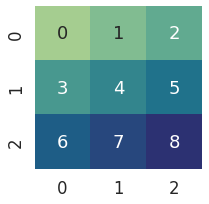

In [ ]:
state_mapping = {0: (0,0), 1: (1,0), 2: (2,0), 3: (0,1), 4: (1,1), 5:(2,1), 6: (0,2), 7:(1,2), 8:(2,2)}
grid = np.zeros((3,3))
for linear_index, xy_coordinates in state_mapping.items():
    x, y = xy_coordinates
    grid[y,x] = linear_index # rows are the y-coordinate, columns are the x-coordinate -- so we index into the grid we'll be visualizing using '[y, x]'
fig = plt.figure(figsize = (3,3))
sns.set(font_scale=1.5)
sns.heatmap(grid, annot=True,  cbar = False, fmt='.0f', cmap='crest')

In [ ]:
A = np.eye(9)
A

array([[1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1.]])

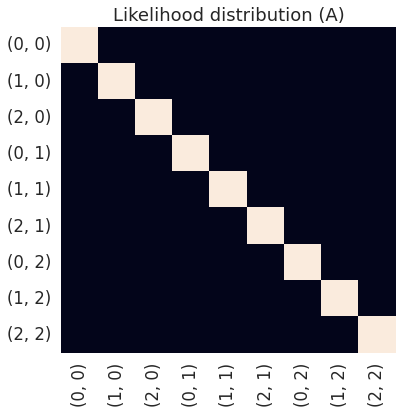

In [ ]:
labels = [state_mapping[i] for i in range(A.shape[1])]
def plot_likelihood(A):
    fig = plt.figure(figsize = (6,6))
    ax = sns.heatmap(A, xticklabels = labels, yticklabels = labels, cbar = False)
    plt.title("Likelihood distribution (A)")
    plt.show()
plot_likelihood(A)

In [ ]:
state_mapping

{0: (0, 0),
 1: (1, 0),
 2: (2, 0),
 3: (0, 1),
 4: (1, 1),
 5: (2, 1),
 6: (0, 2),
 7: (1, 2),
 8: (2, 2)}

In [ ]:
P = {}
dim = 3
actions = {'UP':0, 'RIGHT':1, 'DOWN':2, 'LEFT':3, 'STAY':4}

for state_index, xy_coordinates in state_mapping.items():
    P[state_index] = {a : [] for a in range(len(actions))}
    x, y = xy_coordinates

    '''if your y-coordinate is all the way at the top (i.e. y == 0), you stay in the same place -- otherwise you move one upwards (achieved by subtracting 3 from your linear state index'''
    P[state_index][actions['UP']] = state_index if y == 0 else state_index - dim 

    '''f your x-coordinate is all the way to the right (i.e. x == 2), you stay in the same place -- otherwise you move one to the right (achieved by adding 1 to your linear state index)'''
    P[state_index][actions["RIGHT"]] = state_index if x == (dim -1) else state_index+1 

    '''if your y-coordinate is all the way at the bottom (i.e. y == 2), you stay in the same place -- otherwise you move one down (achieved by adding 3 to your linear state index)'''
    P[state_index][actions['DOWN']] = state_index if y == (dim -1) else state_index + dim 

    ''' if your x-coordinate is all the way at the left (i.e. x == 0), you stay at the same place -- otherwise, you move one to the left (achieved by subtracting 1 from your linear state index)'''
    P[state_index][actions['LEFT']] = state_index if x == 0 else state_index -1 

    ''' Stay in the same place (self explanatory) '''
    P[state_index][actions['STAY']] = state_index

In [ ]:
P

{0: {0: 0, 1: 1, 2: 3, 3: 0, 4: 0},
 1: {0: 1, 1: 2, 2: 4, 3: 0, 4: 1},
 2: {0: 2, 1: 2, 2: 5, 3: 1, 4: 2},
 3: {0: 0, 1: 4, 2: 6, 3: 3, 4: 3},
 4: {0: 1, 1: 5, 2: 7, 3: 3, 4: 4},
 5: {0: 2, 1: 5, 2: 8, 3: 4, 4: 5},
 6: {0: 3, 1: 7, 2: 6, 3: 6, 4: 6},
 7: {0: 4, 1: 8, 2: 7, 3: 6, 4: 7},
 8: {0: 5, 1: 8, 2: 8, 3: 7, 4: 8}}

In [ ]:
num_states = 9
B = np.zeros([num_states, num_states, len(actions)])
for s in range(num_states):
    for a in range(len(actions)):
        ns = int(P[s][a])
        B[ns, s, a] = 1

In [ ]:
B.shape

(9, 9, 5)

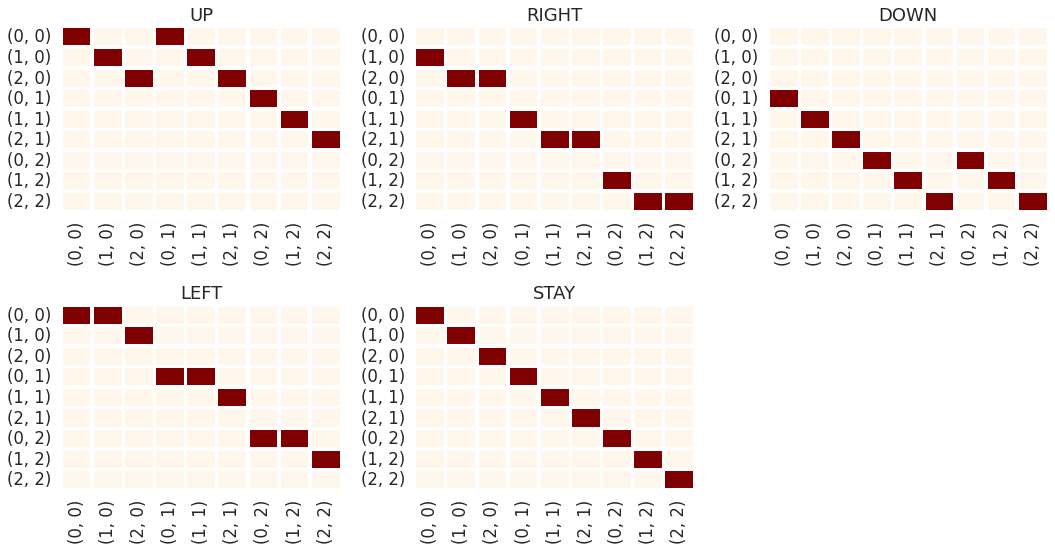

In [ ]:
fig, axes = plt.subplots(2,3, figsize = (15,8))
a = list(actions.keys())
count = 0
for i in range(dim-1):
    for j in range(dim):
        if count >= 5:
            break 
        g = sns.heatmap(B[:,:,count], cmap = "OrRd", linewidth = 2.5, cbar = False, ax = axes[i,j], xticklabels=labels, yticklabels=labels)
        g.set_title(a[count])
        count +=1 
fig.delaxes(axes.flatten()[5])
plt.tight_layout()
plt.show()
    

In [ ]:
state_mapping = {0: (0,0), 1: (1,0), 2: (2,0), 3: (0,1), 4: (1,1), 5:(2,1), 6: (0,2), 7:(1,2), 8:(2,2)}

A = np.eye(9)
def plot_beliefs(Qs, title=""):
    #values = Qs.values[:, 0]
    plt.grid(zorder=0)
    plt.bar(range(Qs.shape[0]), Qs, color='r', zorder=3)
    plt.xticks(range(Qs.shape[0]))
    plt.title(title)
    plt.show()
    
labels = [state_mapping[i] for i in range(A.shape[1])]
def plot_likelihood(A):
    fig = plt.figure(figsize = (6,6))
    ax = sns.heatmap(A, xticklabels = labels, yticklabels = labels, cbar = False)
    plt.title("Likelihood distribution (A)")
    plt.show()
    
def plot_empirical_prior(B):
    fig, axes = plt.subplots(3,2, figsize=(8, 10))
    actions = ['UP', 'RIGHT', 'DOWN', 'LEFT', 'STAY']
    count = 0
    for i in range(3):
        for j in range(2):
            if count >= 5:
                break
                
            g = sns.heatmap(B[:,:,count], cmap="OrRd", linewidth=2.5, cbar=False, ax=axes[i,j])

            g.set_title(actions[count])
            count += 1
    fig.delaxes(axes.flatten()[5])
    plt.tight_layout()
    plt.show()
    
def plot_transition(B):
    fig, axes = plt.subplots(2,3, figsize = (15,8))
    a = list(actions.keys())
    count = 0
    for i in range(dim-1):
        for j in range(dim):
            if count >= 5:
                break 
            g = sns.heatmap(B[:,:,count], cmap = "OrRd", linewidth = 2.5, cbar = False, ax = axes[i,j], xticklabels=labels, yticklabels=labels)
            g.set_title(a[count])
            count +=1 
    fig.delaxes(axes.flatten()[5])
    plt.tight_layout()
    plt.show()

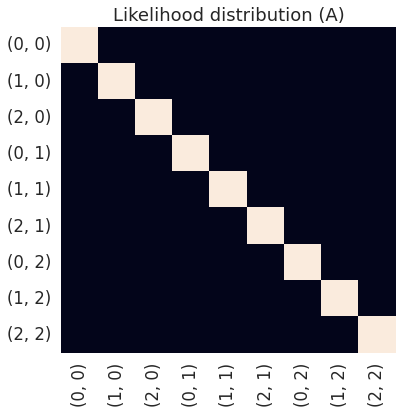

In [ ]:
# A matrix
A = np.eye(9)
plot_likelihood(A)

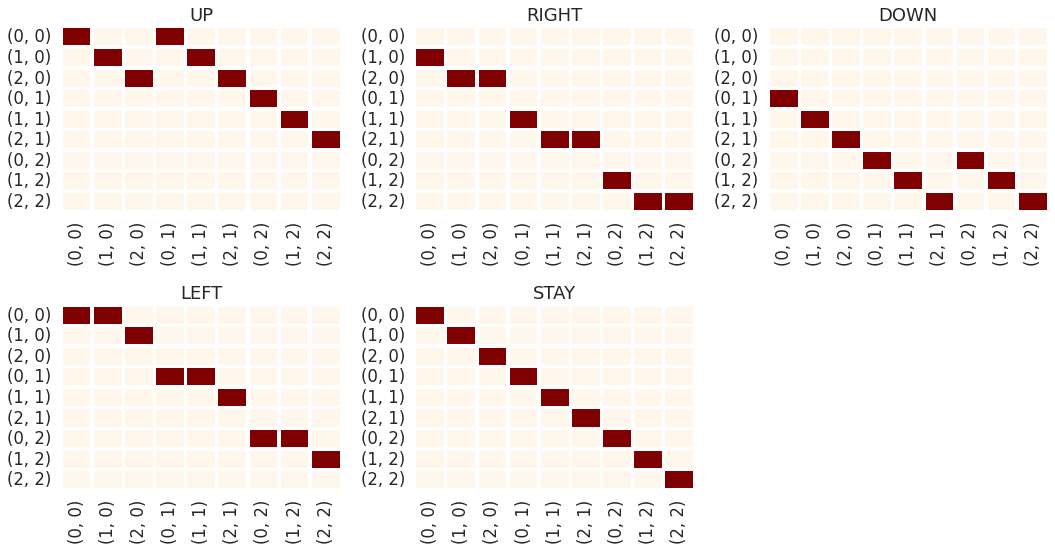

In [ ]:
# construct B matrix

P = {}
dim = 3
actions = {'UP':0, 'RIGHT':1, 'DOWN':2, 'LEFT':3, 'STAY':4}

for state_index, xy_coordinates in state_mapping.items():
    P[state_index] = {a : [] for a in range(len(actions))}
    x, y = xy_coordinates

    '''if your y-coordinate is all the way at the top (i.e. y == 0), you stay in the same place -- otherwise you move one upwards (achieved by subtracting 3 from your linear state index'''
    P[state_index][actions['UP']] = state_index if y == 0 else state_index - dim 

    '''f your x-coordinate is all the way to the right (i.e. x == 2), you stay in the same place -- otherwise you move one to the right (achieved by adding 1 to your linear state index)'''
    P[state_index][actions["RIGHT"]] = state_index if x == (dim -1) else state_index+1 

    '''if your y-coordinate is all the way at the bottom (i.e. y == 2), you stay in the same place -- otherwise you move one down (achieved by adding 3 to your linear state index)'''
    P[state_index][actions['DOWN']] = state_index if y == (dim -1) else state_index + dim 

    ''' if your x-coordinate is all the way at the left (i.e. x == 0), you stay at the same place -- otherwise, you move one to the left (achieved by subtracting 1 from your linear state index)'''
    P[state_index][actions['LEFT']] = state_index if x == 0 else state_index -1 

    ''' Stay in the same place (self explanatory) '''
    P[state_index][actions['STAY']] = state_index


num_states = 9
B = np.zeros([num_states, num_states, len(actions)])
for s in range(num_states):
    for a in range(len(actions)):
        ns = int(P[s][a])
        B[ns, s, a] = 1

plot_transition(B)

In [ ]:
class GridWorldEnv():
    
    def __init__(self,A,B):
        self.A = deepcopy(A)
        self.B = deepcopy(B)
        print("B:", B.shape)
        self.state = np.zeros(9)
        # start at state 3
        self.state[2] = 1
    
    def step(self,a):
        self.state = np.dot(self.B[:,:,a], self.state)
        obs = utils.sample(np.dot(self.A, self.state))
        return obs

    def reset(self):
        self.state =np.zeros(9)
        self.state[2] =1 
        obs = utils.sample(np.dot(self.A, self.state))
        return obs
    
env = GridWorldEnv(A,B)

B: (9, 9, 5)


In [ ]:
def KL_divergence(q,p):
    return np.sum(q * (log_stable(q) - log_stable(p)))

In [ ]:
def compute_free_energy(q,A, B):
    return np.sum(q * (log_stable(q) - log_stable(A) - log_stable(B)))

In [ ]:
def softmax(x):
    return np.exp(x) / np.sum(np.exp(x))

def perform_inference(likelihood, prior):
    return softmax(log_stable(likelihood) + log_stable(prior))

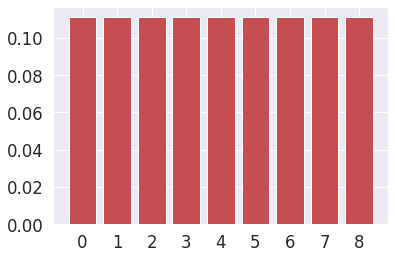

In [ ]:
# setup initial prior beliefs -- uncertain -- completely unknown which state it is in
Qs = np.ones(9) * 1/9
plot_beliefs(Qs)

(1, 2)
[0. 0. 0. 0. 0. 0. 0. 1. 0.]


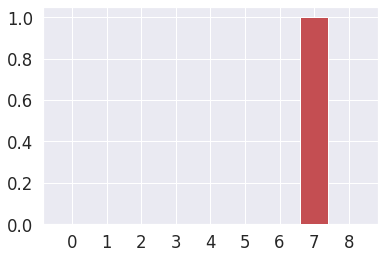

In [ ]:
# C matrix -- desires

REWARD_LOCATION = 7
reward_state = state_mapping[REWARD_LOCATION]
print(reward_state)

C = np.zeros(num_states)
C[REWARD_LOCATION] = 1. 
print(C)
plot_beliefs(C)

In [ ]:
def evaluate_policy(policy, Qs, A, B, C):
    # initialize expected free energy at 0
    G = 0

    # loop over policy
    for t in range(len(policy)):

        # get action entailed by the policy at timestep `t`
        u = int(policy[t])

        # work out expected state, given the action
        Qs_pi = B[:,:,u].dot(Qs)

        # work out expected observations, given the action
        Qo_pi = A.dot(Qs_pi)

        # get entropy
        H = - (A * log_stable(A)).sum(axis = 0)

        # get predicted divergence
        # divergence = np.sum(Qo_pi * (log_stable(Qo_pi) - log_stable(C)), axis=0)
        divergence = KL_divergence(Qo_pi, C)
        
        # compute the expected uncertainty or ambiguity 
        uncertainty = H.dot(Qs_pi)

        # increment the expected free energy counter for the policy, using the expected free energy at this timestep
        G += (divergence + uncertainty)

    return -G

In [ ]:
def infer_action(Qs, A, B, C, n_actions, policies):
    
    # initialize the negative expected free energy
    neg_G = np.zeros(len(policies))

    # loop over every possible policy and compute the EFE of each policy
    for i, policy in enumerate(policies):
        neg_G[i] = evaluate_policy(policy, Qs, A, B, C)

    # get distribution over policies
    Q_pi = maths.softmax(neg_G)

    # initialize probabilites of control states (convert from policies to actions)
    Qu = np.zeros(n_actions)

    # sum probabilites of control states or actions 
    for i, policy in enumerate(policies):
        # control state specified by policy
        u = int(policy[0])
        # add probability of policy
        Qu[u] += Q_pi[i]

    # normalize action marginal
    utils.norm_dist(Qu)

    # sample control from action marginal
    u = utils.sample(Qu)

    return u

[0. 0. 0. 0. 0. 1. 0. 0. 0.]


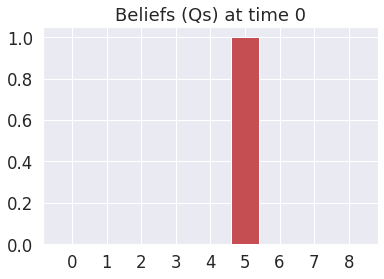

[0. 0. 1. 0. 0. 0. 0. 0. 0.]


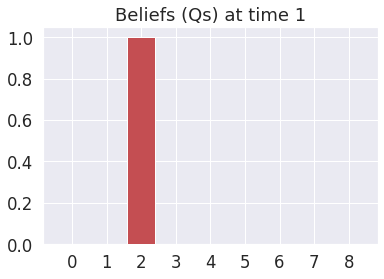

[0. 0. 1. 0. 0. 0. 0. 0. 0.]


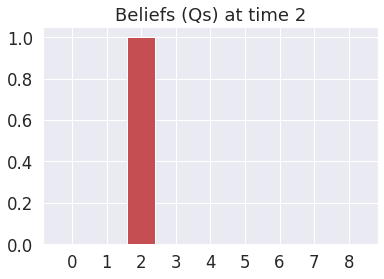

[0. 1. 0. 0. 0. 0. 0. 0. 0.]


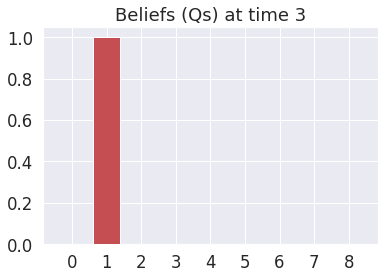

[0. 1. 0. 0. 0. 0. 0. 0. 0.]


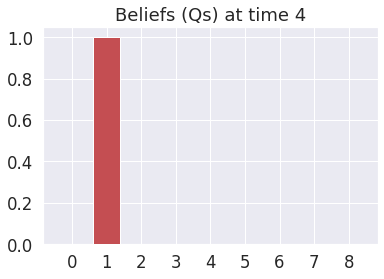

[0. 1. 0. 0. 0. 0. 0. 0. 0.]


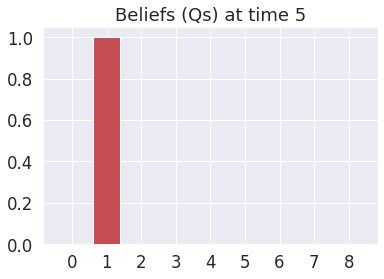

[0. 1. 0. 0. 0. 0. 0. 0. 0.]


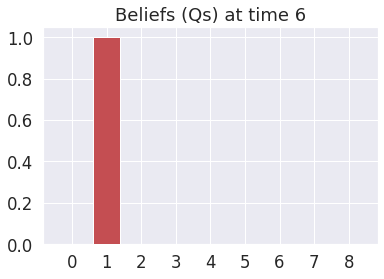

[0. 0. 1. 0. 0. 0. 0. 0. 0.]


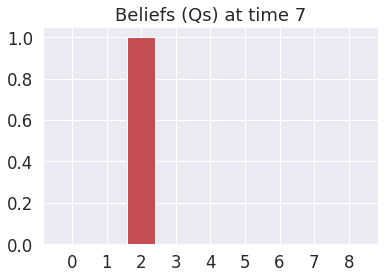

[0. 0. 0. 0. 0. 1. 0. 0. 0.]


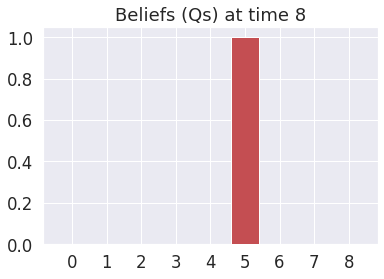

[0. 0. 0. 0. 0. 0. 0. 0. 1.]


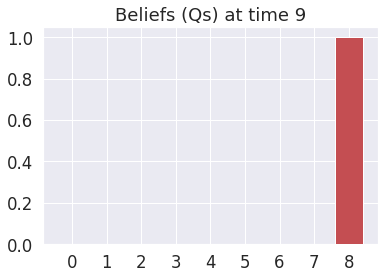

In [ ]:
# number of time steps
T = 10

#n_actions = env.n_control
n_actions = 5

# length of policies we consider
policy_len = 4

# this function generates all possible combinations of policies
policies = control.construct_policies([B.shape[0]], [n_actions], policy_len)

# reset environment
o = env.reset()

# loop over time
for t in range(T):

    # infer which action to take
    a = infer_action(Qs, A, B, C, n_actions, policies)
    
    # perform action in the environment and update the environment
    o = env.step(int(a))
    
    # infer new hidden state (this is the same equation as above but with PyMDP functions)
    likelihood = A[o,:]
    prior = B[:,:,int(a)].dot(Qs)

    Qs = maths.softmax(log_stable(likelihood) + log_stable(prior))
    
    print(Qs.round(3))
    plot_beliefs(Qs, "Beliefs (Qs) at time {}".format(t))

Attempt

In [ ]:
import pymdp
from pymdp import utils
from pymdp.agent import Agent

num_obs = [3, 5] # observation modality dimensions
num_states = [4, 2, 3] # hidden state factor dimensions
num_controls = [4, 1, 1] # control state factor dimensions
A_array = utils.random_A_matrix(num_obs, num_states) # create sensory likelihood (A matrix)
B_array = utils.random_B_matrix(num_states, num_controls) # create transition likelihood (B matrix)

C_vector = utils.obj_array_uniform(num_obs) # uniform preferences

# instantiate a quick agent using your A, B and C arrays
my_agent = Agent( A = A_array, B = B_array, C = C_vector)

# give the agent a random observation and get the optimized posterior beliefs

observation = [1, 4] # a list specifying the indices of the observation, for each observation modality

qs = my_agent.infer_states(observation) # get posterior over hidden states (a multi-factor belief)

# Do active inference

q_pi, neg_efe = my_agent.infer_policies() # return the policy posterior and return (negative) expected free energies of each policy as well

action = my_agent.sample_action() # sample an action from the posterior over policies

ModuleNotFoundError: ignored

In [ ]:
action

array([0., 0., 0.])

In [ ]:
!pip uninstall pymdp

Found existing installation: pymdp 0.0.1
Uninstalling pymdp-0.0.1:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/pymdp-0.0.1.dist-info/*
    /usr/local/lib/python3.7/dist-packages/pymdp/*
Proceed (y/n)? y
  Successfully uninstalled pymdp-0.0.1


In [ ]:
!pip install inferactively-pymdp numpy copy

     |████████████████████████████████| 60 kB 1.9 MB/s 
ERROR: Could not find a version that satisfies the requirement copy (from versions: none)
ERROR: No matching distribution found for copy


changed attempt

In [ ]:
import pymdp
from pymdp import utils
from pymdp.agent import Agent
import numpy as np
import copy


# TODO : Use `age` state to influence epistemic value (via influencing preference strength for health)
# TODO : Build in differences between pathogens; different squares could have different volatilities (both "good" and "bad" - some pathogens should be avoided period)


## Observations
###space colors (microbiome and environmental constraint) : red, blue, green for each square
###age : 0-30
###location : 0,1,2,3,4,5,6,7,8
###symptom1 : yes, no
###symptom2 : yes, no
###symptom3 : yes, no
###"b_m_1":["yes", "no"],
###"b_m_2":["yes", "no"],
###"b_m_3":["yes", "no"]


##States
###Health load : not loaded, a little loaded, overloaded
###location:  0,1,2,3,4,5,6,7,8
###space color : red, blue, green for each square
###age: 0- 30
###has had sym1 :yes, no
###has had symp2 : yes, no
###has had symp3 : yes, no

### things that are related
##space color and location
##Generate a grid with those properties
##symptom and bm are related
##add a property to the agent of the biomarker
## age is defined by the Time t


### Actual world grid
Grid  = [0,1,2,0,1,2,0,1,2]

###b matrix of the grid changing to another color in the generative process
##0-0, 0-1, 0-2, 1-0,1-1, 1-2, 2-0, 2-1, 2-2
Grid_B = np.zeros((3,3))
Grid_B[:,:] = .05
Grid_B[0,0] = .9
Grid_B[1,1] = .9
Grid_B[2,2] = .9


observations = {
    "space_colors" : np.vstack(["red", "blue", "green"]*9),
    "age" : [i for i in range(30)],
    "location" : [0,1,2,3,4,5,6,7,8],
    "symptom_red" : ["no", "yes"],
    "symptom_blue" : ["no", "yes"],
    "symptom_green" : ["no", "yes"],
    "b_m_red":["no", "yes"],
    "b_m_blue":["no", "yes"],
    "b_m_green":["no", "yes"]
}


states = {
    # "space_colors_row_0" : ["red", "blue", "green"], # Factor into columns and rows
    # "space_colors_row_1" : ["red", "blue", "green"],
    # "space_colors_row_2" : ["red", "blue", "green"],
    # "space_colors_col_0" : ["red", "blue", "green"],
    # "space_colors_col_1" : ["red", "blue", "green"],
    # "space_colors_col_2" : ["red", "blue", "green"],
    "space_colors" : np.vstack(["red", "blue", "green"]*9),
    "age" : [i for i in range(30)], 
    "location" : [0,1,2,3,4,5,6,7,8],
    "has had symp_red" : ["no", "yes"],
    "has had symp_blue" : ["no", "yes"],
    "has had symp_green" : ["no", "yes"],
    "Health_load" : ["not loaded", "a little loaded", "overloaded"],
    
}



actions = {
    "change_location"  : ["go up", "go down", "go right", "go left", "stay" ]
}

###movement on the grid


num_obs = [3,3,3,3,3,3,3,3,3, 30, 9, 2, 2, 2,2,2,2] # observation modality dimensions
num_states = [3,3,3,3,3,3,3,3,3, 30, 9, 2, 2, 2,2,2,2, 3] # hidden state factor dimensions
num_controls = [1,1,1,1,1,1,1,1,1,1,5,1,1,1,1,1,1,1] # control state factor dimensions
num_factors = len(num_states)

A_space_colors_0 = np.zeros((3,3,3,3,3,3,3,3,3,3,30,9,2,2,2,3))
A_space_colors_1 = np.zeros((3,3,3,3,3,3,3,3,3,3,30,9,2,2,2,3))
A_space_colors_2 = np.zeros((3,3,3,3,3,3,3,3,3,3,30,9,2,2,2,3))
A_space_colors_3 = np.zeros((3,3,3,3,3,3,3,3,3,3,30,9,2,2,2,3))
A_space_colors_4 = np.zeros((3,3,3,3,3,3,3,3,3,3,30,9,2,2,2,3))
A_space_colors_5 = np.zeros((3,3,3,3,3,3,3,3,3,3,30,9,2,2,2,3))
A_space_colors_6 = np.zeros((3,3,3,3,3,3,3,3,3,3,30,9,2,2,2,3))
A_space_colors_7 = np.zeros((3,3,3,3,3,3,3,3,3,3,30,9,2,2,2,3))
A_space_colors_8 = np.zeros((3,3,3,3,3,3,3,3,3,3,30,9,2,2,2,3))
A_age = np.zeros((30,3,3,3,3,3,3,3,3,3,30,9,2,2,2,3))
A_location = np.zeros((9,3,3,3,3,3,3,3,3,3,30,9,2,2,2,3))
A_symp_red = np.zeros((2,3,3,3,3,3,3,3,3,3,30,9,2,2,2,3))
A_symp_blue = np.zeros((2,3,3,3,3,3,3,3,3,3,30,9,2,2,2,3))
A_symp_green = np.zeros((2,3,3,3,3,3,3,3,3,3,30,9,2,2,2,3))
A_bm_red = np.zeros((2,3,3,3,3,3,3,3,3,3,30,9,2,2,2,3))
A_bm_blue = np.zeros((2,3,3,3,3,3,3,3,3,3,30,9,2,2,2,3))
A_bm_green = np.zeros((2,3,3,3,3,3,3,3,3,3,30,9,2,2,2,3))

for i in range(num_obs[0]):
  A_space_colors_0[i][i,:,:,:,:,:,:,:,:,:,:,:,:,:,:] = 1
  A_space_colors_1[i][:,i,:,:,:,:,:,:,:,:,:,:,:,:,:] = 1
  A_space_colors_2[i][:,:,i,:,:,:,:,:,:,:,:,:,:,:,:] = 1
  A_space_colors_3[i][:,:,:,i,:,:,:,:,:,:,:,:,:,:,:] = 1
  A_space_colors_4[i][:,:,:,:,i,:,:,:,:,:,:,:,:,:,:] = 1
  A_space_colors_5[i][:,:,:,:,:,i,:,:,:,:,:,:,:,:,:] = 1
  A_space_colors_6[i][:,:,:,:,:,:,i,:,:,:,:,:,:,:,:] = 1
  A_space_colors_7[i][:,:,:,:,:,:,:,i,:,:,:,:,:,:,:] = 1
  A_space_colors_8[i][:,:,:,:,:,:,:,:,i,:,:,:,:,:,:] = 1

for j in range(num_obs[9]):
  A_age[j][:,:,:,:,:,:,:,:,j,:,:,:,:,:,:] = 1


for i in range(num_obs[10]):
  A_location[i][:,:,:,:,:,:,:,:,:,i,:,:,:,:,:] = 1

# Likelihood of observing symptom not red given that your health load is not loaded
A_sym_red[0][:,:,:,:,:,:,:,:,:,:,:,:,:,:,0] = 1


# Likelihood of observing symptom red given that your health load is a little loaded and that you are on a red square and hasn't had the red symptom

A_sym_red[1][0,:,:,:,:,:,:,:,:,:,0,0,:,:,1] = .5
A_sym_red[1][:,0,:,:,:,:,:,:,:,:,1,0,:,:,1] = .5
A_sym_red[1][:,:,0,:,:,:,:,:,:,:,2,0,:,:,1] = .5
A_sym_red[1][:,:,:,0,:,:,:,:,:,:,3,0,:,:,1] = .5
A_sym_red[1][:,:,:,:,0,:,:,:,:,:,4,0,:,:,1] = .5
A_sym_red[1][:,:,:,:,:,0,:,:,:,:,5,0,:,:,1] = .5
A_sym_red[1][:,:,:,:,:,:,0,:,:,:,6,0,:,:,1] = .5
A_sym_red[1][:,:,:,:,:,:,:,0,:,:,7,0,:,:,1] = .5
A_sym_red[1][:,:,:,:,:,:,:,:,0,:,8,0,:,:,1] = .5

# Likelihood of observing symptom red given that your health load is overloaded and that you are on a red square and hasn't had the red symptom

A_sym_red[1][0,:,:,:,:,:,:,:,:,:,0,0,:,:,2] = 1
A_sym_red[1][:,0,:,:,:,:,:,:,:,:,1,0,:,:,2] = 1
A_sym_red[1][:,:,0,:,:,:,:,:,:,:,2,0,:,:,2] = 1
A_sym_red[1][:,:,:,0,:,:,:,:,:,:,3,0,:,:,2] = 1
A_sym_red[1][:,:,:,:,0,:,:,:,:,:,4,0,:,:,2] = 1
A_sym_red[1][:,:,:,:,:,0,:,:,:,:,5,0,:,:,2] = 1
A_sym_red[1][:,:,:,:,:,:,0,:,:,:,6,0,:,:,2] = 1
A_sym_red[1][:,:,:,:,:,:,:,0,:,:,7,0,:,:,2] = 1
A_sym_red[1][:,:,:,:,:,:,:,:,0,:,8,0,:,:,2] = 1

# Likelihood of observing symptom red given that your health load is a little loaded and that you are not on a red square and has had the red symptom
A_sym_red[1][:,:,:,:,:,:,:,:,:,:,:,1,:,:,1] = .1

# Likelihood of observing symptom red given that your health load is a little loaded and that you are on a red square and has had the red symptom

A_sym_red[1][0,:,:,:,:,:,:,:,:,:,0,1,:,:,1] = .3
A_sym_red[1][:,0,:,:,:,:,:,:,:,:,1,1,:,:,1] = .3
A_sym_red[1][:,:,0,:,:,:,:,:,:,:,2,1,:,:,1] = .3
A_sym_red[1][:,:,:,0,:,:,:,:,:,:,3,1,:,:,1] = .3
A_sym_red[1][:,:,:,:,0,:,:,:,:,:,4,1,:,:,1] = .3
A_sym_red[1][:,:,:,:,:,0,:,:,:,:,5,1,:,:,1] = .3
A_sym_red[1][:,:,:,:,:,:,0,:,:,:,6,1,:,:,1] = .3
A_sym_red[1][:,:,:,:,:,:,:,0,:,:,7,1,:,:,1] = .3
A_sym_red[1][:,:,:,:,:,:,:,:,0,:,8,1,:,:,1] = .3

# Likelihood of observing symptom red given that your health load is overloaded and that you are on a red square and has had the red symptom

A_sym_red[1][0,:,:,:,:,:,:,:,:,:,0,1,:,:,2] = 1
A_sym_red[1][:,0,:,:,:,:,:,:,:,:,1,1,:,:,2] = 1
A_sym_red[1][:,:,0,:,:,:,:,:,:,:,2,1,:,:,2] = 1
A_sym_red[1][:,:,:,0,:,:,:,:,:,:,3,1,:,:,2] = 1
A_sym_red[1][:,:,:,:,0,:,:,:,:,:,4,1,:,:,2] = 1
A_sym_red[1][:,:,:,:,:,0,:,:,:,:,5,1,:,:,2] = 1
A_sym_red[1][:,:,:,:,:,:,0,:,:,:,6,1,:,:,2] = 1
A_sym_red[1][:,:,:,:,:,:,:,0,:,:,7,1,:,:,2] = 1
A_sym_red[1][:,:,:,:,:,:,:,:,0,:,8,1,:,:,2] = 1


# Likelihood of observing symptom not blue given that your health load is not loaded
A_sym_blue[0][:,:,:,:,:,:,:,:,:,:,:,:,:,:,0] = 1

# Likelihood of observing symptom blue given that your health load is a little loaded and that you are not on a blue square and has had the blue symptom
A_sym_blue[1][:,:,:,:,:,:,:,:,:,:,:,:,1,:,1] = .1


# Likelihood of observing symptom blue given that your health load is a little loaded and that you are on a blue square and that you haven't had the blue symptom

A_sym_blue[1][1,:,:,:,:,:,:,:,:,:,0,:,0,:,1] = .5
A_sym_blue[1][:,1,:,:,:,:,:,:,:,:,1,:,0,:,1] = .5
A_sym_blue[1][:,:,1,:,:,:,:,:,:,:,2,:,0,:,1] = .5
A_sym_blue[1][:,:,:,1,:,:,:,:,:,:,3,:,0,:,1] = .5
A_sym_blue[1][:,:,:,:,1,:,:,:,:,:,4,:,0,:,1] = .5
A_sym_blue[1][:,:,:,:,:,1,:,:,:,:,5,:,0,:,1] = .5
A_sym_blue[1][:,:,:,:,:,:,1,:,:,:,6,:,0,:,1] = .5
A_sym_blue[1][:,:,:,:,:,:,:,1,:,:,7,:,0,:,1] = .5
A_sym_blue[1][:,:,:,:,:,:,:,:,1,:,8,:,0,:,1] = .5

# Likelihood of observing symptom blue given that your health load is overloaded and that you are on a blue square an that you haven't had the blue symptom

A_sym_blue[1][1,:,:,:,:,:,:,:,:,:,0,:,0,:,2] = 1
A_sym_blue[1][:,1,:,:,:,:,:,:,:,:,1,:,0,:,2] = 1
A_sym_blue[1][:,:,1,:,:,:,:,:,:,:,2,:,0,:,2] = 1
A_sym_blue[1][:,:,:,1,:,:,:,:,:,:,3,:,0,:,2] = 1
A_sym_blue[1][:,:,:,:,1,:,:,:,:,:,4,:,0,:,2] = 1
A_sym_blue[1][:,:,:,:,:,1,:,:,:,:,5,:,0,:,2] = 1
A_sym_blue[1][:,:,:,:,:,:,1,:,:,:,6,:,0,:,2] = 1
A_sym_blue[1][:,:,:,:,:,:,:,1,:,:,7,:,0,:,2] = 1
A_sym_blue[1][:,:,:,:,:,:,:,:,1,:,8,:,0,:,2] = 1

# Likelihood of observing symptom blue given that your health load is a little loaded and that you are on a blue square and that you have had the blue symptom

A_sym_blue[1][1,:,:,:,:,:,:,:,:,:,0,:,1,:,1] = .3
A_sym_blue[1][:,1,:,:,:,:,:,:,:,:,1,:,1,:,1] = .3
A_sym_blue[1][:,:,1,:,:,:,:,:,:,:,2,:,1,:,1] = .3
A_sym_blue[1][:,:,:,1,:,:,:,:,:,:,3,:,1,:,1] = .3
A_sym_blue[1][:,:,:,:,1,:,:,:,:,:,4,:,1,:,1] = .3
A_sym_blue[1][:,:,:,:,:,1,:,:,:,:,5,:,1,:,1] = .3
A_sym_blue[1][:,:,:,:,:,:,1,:,:,:,6,:,1,:,1] = .3
A_sym_blue[1][:,:,:,:,:,:,:,1,:,:,7,:,1,:,1] = .3
A_sym_blue[1][:,:,:,:,:,:,:,:,1,:,8,:,1,:,1] = .3

# Likelihood of observing symptom blue given that your health load is overloaded and that you are on a blue square an that you have had the blue symptom

A_sym_blue[1][1,:,:,:,:,:,:,:,:,:,0,:,1,:,2] = 1
A_sym_blue[1][:,1,:,:,:,:,:,:,:,:,1,:,1,:,2] = 1
A_sym_blue[1][:,:,1,:,:,:,:,:,:,:,2,:,1,:,2] = 1
A_sym_blue[1][:,:,:,1,:,:,:,:,:,:,3,:,1,:,2] = 1
A_sym_blue[1][:,:,:,:,1,:,:,:,:,:,4,:,1,:,2] = 1
A_sym_blue[1][:,:,:,:,:,1,:,:,:,:,5,:,1,:,2] = 1
A_sym_blue[1][:,:,:,:,:,:,1,:,:,:,6,:,1,:,2] = 1
A_sym_blue[1][:,:,:,:,:,:,:,1,:,:,7,:,1,:,2] = 1
A_sym_blue[1][:,:,:,:,:,:,:,:,1,:,8,:,1,:,2] = 1


# Likelihood of observing symptom not green given that your health load is not loaded
A_sym_green[0][:,:,:,:,:,:,:,:,:,:,:,:,:,:,0] = 1

# Likelihood of observing symptom green given that your health load is a little loaded and that you are not on a green square and has had the green symptom
A_sym_green[1][:,:,:,:,:,:,:,:,:,:,:,:,:,1,1] = .1


# Likelihood of observing symptom green given that your health load is a little loaded and that you are on a green square and that you haven't had the green symptom

A_sym_green[1][2,:,:,:,:,:,:,:,:,:,0,:,:,0,1] = .5
A_sym_green[1][:,2,:,:,:,:,:,:,:,:,1,:,:,0,1] = .5
A_sym_green[1][:,:,2,:,:,:,:,:,:,:,2,:,:,0,1] = .5
A_sym_green[1][:,:,:,2,:,:,:,:,:,:,3,:,:,0,1] = .5
A_sym_green[1][:,:,:,:,2,:,:,:,:,:,4,:,:,0,1] = .5
A_sym_green[1][:,:,:,:,:,2,:,:,:,:,5,:,:,0,1] = .5
A_sym_green[1][:,:,:,:,:,:,2,:,:,:,6,:,:,0,1] = .5
A_sym_green[1][:,:,:,:,:,:,:,2,:,:,7,:,:,0,1] = .5
A_sym_green[1][:,:,:,:,:,:,:,:,2,:,8,:,:,0,1] = .5

# Likelihood of observing symptom green given that your health load is overloaded and that you are on a green square and that you haven't had the green symptom

A_sym_green[1][2,:,:,:,:,:,:,:,:,:,0,:,:,0,2] = 1
A_sym_green[1][:,2,:,:,:,:,:,:,:,:,1,:,:,0,2] = 1
A_sym_green[1][:,:,2,:,:,:,:,:,:,:,2,:,:,0,2] = 1
A_sym_green[1][:,:,:,2,:,:,:,:,:,:,3,:,:,0,2] = 1
A_sym_green[1][:,:,:,:,2,:,:,:,:,:,4,:,:,0,2] = 1
A_sym_green[1][:,:,:,:,:,2,:,:,:,:,5,:,:,0,2] = 1
A_sym_green[1][:,:,:,:,:,:,2,:,:,:,6,:,:,0,2] = 1
A_sym_green[1][:,:,:,:,:,:,:,2,:,:,7,:,:,0,2] = 1
A_sym_green[1][:,:,:,:,:,:,:,:,2,:,8,:,:,0,2] = 1

# Likelihood of observing symptom green given that your health load is a little loaded and that you are on a green square and that you have had the green symptom

A_sym_green[1][2,:,:,:,:,:,:,:,:,:,0,:,:,1,1] = .3
A_sym_green[1][:,2,:,:,:,:,:,:,:,:,1,:,:,1,1] = .3
A_sym_green[1][:,:,2,:,:,:,:,:,:,:,2,:,:,1,1] = .3
A_sym_green[1][:,:,:,2,:,:,:,:,:,:,3,:,:,1,1] = .3
A_sym_green[1][:,:,:,:,2,:,:,:,:,:,4,:,:,1,1] = .3
A_sym_green[1][:,:,:,:,:,2,:,:,:,:,5,:,:,1,1] = .3
A_sym_green[1][:,:,:,:,:,:,2,:,:,:,6,:,:,1,1] = .3
A_sym_green[1][:,:,:,:,:,:,:,2,:,:,7,:,:,1,1] = .3
A_sym_green[1][:,:,:,:,:,:,:,:,2,:,8,:,:,1,1] = .3

# Likelihood of observing symptom green given that your health load is overloaded and that you are on a green square and that you have had the green symptom

A_sym_green[1][2,:,:,:,:,:,:,:,:,:,0,:,:,1,2] = 1
A_sym_green[1][:,2,:,:,:,:,:,:,:,:,1,:,:,1,2] = 1
A_sym_green[1][:,:,2,:,:,:,:,:,:,:,2,:,:,1,2] = 1
A_sym_green[1][:,:,:,2,:,:,:,:,:,:,3,:,:,1,2] = 1
A_sym_green[1][:,:,:,:,2,:,:,:,:,:,4,:,:,1,2] = 1
A_sym_green[1][:,:,:,:,:,2,:,:,:,:,5,:,:,1,2] = 1
A_sym_green[1][:,:,:,:,:,:,2,:,:,:,6,:,:,1,2] = 1
A_sym_green[1][:,:,:,:,:,:,:,2,:,:,7,:,:,1,2] = 1
A_sym_green[1][:,:,:,:,:,:,:,:,2,:,8,:,:,1,2] = 1



# BIOMARKERS  
# Likelihood of red biomarker observation given that you've had the red symptom
A_bm_red[1][:,:,:,:,:,:,:,:,:,:,:,1,:,:,:] = 1

# Likelihood of red biomarker observation given that you've had the red symptom
A_bm_blue[1][:,:,:,:,:,:,:,:,:,:,:,:,1,:,:] = 1

# Likelihood of red biomarker observation given that you've had the red symptom
A_bm_green[1][:,:,:,:,:,:,:,:,:,:,:,:,:,1,:] = 1



#TODO : Fill in A matrices for agent 

A = utils.obj_array_zeros([[num] + num_states for num in num_obs])
A[0] = A_space_colors
A[1] = A_space_colors
A[2] = A_space_colors
A[3] = A_space_colors
A[4] = A_space_colors
A[5] = A_space_colors
A[6] = A_space_colors
A[7] = A_space_colors
A[8] = A_space_colors
A[9] = A_age
A[10] = A_location
A[11] = A_symp_red
A[12] = A_symp_blue
A[13] = A_symp_green
A[14] = A_bm_red
A[15] = A_bm_blue
A[16] = A_bm_green

#A[:] = [A_space_colors, A_age, A_location, A_s1, A_s2,A_s3,A_bm1,A_bm2,A_bm1=3 ], dtype=object)  #TO TRY LATER

B_space_colors = np.zeros((3,3,1))
B_space_colors[:,:,:] = .05
for i in range(3):
  B_space_colors[i,i,:] = .9
B_space_colors_0 = copy.deepcopy(B_space_colors)
B_space_colors_1 = copy.deepcopy(B_space_colors)
B_space_colors_2 = copy.deepcopy(B_space_colors)
B_space_colors_3 = copy.deepcopy(B_space_colors)
B_space_colors_4 = copy.deepcopy(B_space_colors)
B_space_colors_5 = copy.deepcopy(B_space_colors)
B_space_colors_6 = copy.deepcopy(B_space_colors)
B_space_colors_7 = copy.deepcopy(B_space_colors)
B_space_colors_8 = copy.deepcopy(B_space_colors)

B_age = np.zeros((30,30,1))
for i in range(29):
  B_age[i+1,i,:] = 1


B_symp_red = np.zeros((2,2,1))
B_symp_red[1,0,:] = 0.5
B_symp_red[0,0,:] = 0.5
B_symp_red[1,1,:] = 1

B_symp_blue = np.zeros((2,2,1))
B_symp_blue[1,0,:] = 0.5
B_symp_blue[0,0,:] = 0.5
B_symp_blue[1,1,:] = 1

B_symp_green = np.zeros((2,2,1))
B_symp_green[1,0,:] = 0.5
B_symp_green[0,0,:] = 0.5
B_symp_green[1,1,:] = 1


B_health_load = np.expand_dims(np.array([  [1 , .4,  0],
                       [0 , .6,  .4],  
                       [0 ,  0,  .6],
                      ]), 2) 


 ### All possible movements given the grid 
B_location = np.zeros((9,9,5))

B_location[0,1,3] = 1
B_location[0,3,0] = 1
B_location[0,0,4] = 1
B_location[1,0,2] = 1
B_location[1,4,0] = 1
B_location[1,2,3] = 1
B_location[1,1,4] = 1
B_location[2,1,2] = 1
B_location[2,5,0] = 1
B_location[2,2,4] = 1
B_location[2,2,4] = 1
B_location[3,0,1] = 1
B_location[3,4,3] = 1
B_location[3,6,0] = 1
B_location[3,3,4] = 1
B_location[4,1,1] = 1
B_location[4,5,3] = 1
B_location[4,7,0] = 1
B_location[4,3,2] = 1
B_location[4,4,4] = 1
B_location[5,2,1] = 1
B_location[5,4,2] = 1
B_location[5,8,0] = 1
B_location[5,5,4] = 1
B_location[6,3,1] = 1
B_location[6,7,3] = 1
B_location[6,6,1] = 1
B_location[7,6,2] = 1
B_location[7,4,1] = 1
B_location[7,8,3] = 1
B_location[7,7,4] = 1
B_location[8,7,2] = 1
B_location[8,5,1] = 1
B_location[8,8,4] = 1

B = utils.obj_array_zeros([[ns, ns, num_controls[f]] for f, ns in enumerate(num_states)])
B[0] = B_space_colors_0
B[1] = B_space_colors_1
B[2] = B_space_colors_2
B[3] = B_space_colors_3
B[4] = B_space_colors_4
B[5] = B_space_colors_5
B[6] = B_space_colors_6
B[7] = B_space_colors_7
B[8] = B_space_colors_8
B[9] = B_age
B[10] = B_location
B[11] = B_symp_red
B[12] = B_symp_blue
B[13] = B_symp_green
B[14] = B_health_load


C_symp_red = np.zeros(2)
C_symp_red[0] = 1

C_symp_blue = np.zeros(2)
C_symp_blue[0] = 1

C_symp_green = np.zeros(2)
C_symp_green[0] = 1

C_bm_red = np.zeros(2)
C_bm_red[1] = 1

C_bm_blue = np.zeros(2)
C_bm_blue[1] = 1

C_bm_green = np.zeros(2)
C_bm_green[1] = 1

C = utils.obj_array_zeros([no for no in num_obs])
C[11] = C_symp_red
C[12] = C_symp_blue
C[13] = C_symp_green
C[14] = C_bm_red
C[15] = C_bm_blue
C[16] = C_bm_green


# D_space_colors = np.zeros(3)
# D_age = np.zeros(30)
# D_location = np.zeros(9)
# D_symp_red = np.zeros(2)
# D_symp_blue = np.zeros(2)
# D_symp_green = np.zeros(2)
# D_health_load = np.zeros(3)

D = utils.obj_array(len(num_states))
# Flat priors over all states
for factor_idx in range(num_factors):
    D[factor_idx] = np.ones(num_states[factor_idx]) / num_states[factor_idx]

#A_gen_process = A
#B_gen_process = B
# instantiate a quick agent using your A, B and C arrays
my_agent = Agent( A = A, B = B, C = C, D = D)
my_agent["grid"]= Grid

# give the agent a random observation and get the optimized posterior beliefs
changed_grid = Grid
observation = changed_grid + [0,0,0,0,0,1,0,0] # a list specifying the indices of the observation, for each observation modality
state = changed_grid + [0,0,0,0,0,1,0,0]
location_state = state[10]


# p(symptom | color at current location, biomarker, health load)
gen_A_symptoms_red = np.zeros((2,3,2,3))

# Condition: observe red symptom | square is red, biomarker is absent, and health is not loaded
gen_A_symptoms_red[1,0,0,0] = .8

# Condition: observe red symptom | square is  red, biomarker is absent, and health is a little loaded
gen_A_symptoms_red[1,0,0,1] = .9

# Condition: observe red symptom | square is  red, biomarker is absent, and health is overloaded
gen_A_symptoms_red[1,0,0,2] = 1.

# Condition: observe red symptom | square is  red, biomarker is present, and health is not loaded
gen_A_symptoms_red[1,0,1,0] = 0.1

# Condition: observe red symptom | square is  red, biomarker is present, and health is a little loaded
gen_A_symptoms_red[1,0,1,1] = 0.3

# Condition: observe red symptom | square is  red, biomarker is present, and health is overloaded
gen_A_symptoms_red[1,0,1,2] = 0.6

# p(symptom | color at current location, biomarker, health load)
gen_A_symptoms_green = np.zeros((2,3,2,3))

# Condition: observe green symptom | square is green, biomarker is absent, and health is not loaded
gen_A_symptoms_green[1,2,0,0] = .8

# Condition: observe green symptom | square is  green, biomarker is absent, and health is a little loaded
gen_A_symptoms_green[1,2,0,1] = .9

# Condition: observe green symptom | square is  green, biomarker is absent, and health is overloaded
gen_A_symptoms_green[1,2,0,2] = 1.

# Condition: observe green symptom | square is green,  biomarker is present, and health is not loaded
gen_A_symptoms_green[1,2,1,0] = 0.1

# Condition: observe green symptom | square is  green, biomarker is present, and health is a little loaded
gen_A_symptoms_green[1,2,1,1] = 0.3

# Condition: observe green symptom | square is green, biomarker is present, and health is overloaded
gen_A_symptoms_green[1,2,1,2] = 0.6

# p(symptom | color at current location, biomarker, health load)
gen_A_symptoms_blue = np.zeros((2,3,2,3))

# Condition: observe blue symptom | square is blue, biomarker is absent, and health is not loaded
gen_A_symptoms_blue[1,1,0,0] = .8

# Condition: observe blue symptom | square is blue, biomarker is absent, and health is a little loaded
gen_A_symptoms_blue[1,1,0,1] = .9

# Condition: observe blue symptom | square is blue, biomarker is absent, and health is overloaded
gen_A_symptoms_blue[1,1,0,2] = 1.

# Condition: observe blue symptom | square is blue,  biomarker is present, and health is not loaded
gen_A_symptoms_blue[1,1,1,0] = 0.1

# Condition: observe blue symptom | square is blue, biomarker is present, and health is a little loaded
gen_A_symptoms_blue[1,1,1,1] = 0.3

# Condition: observe blue symptom | square is blue, biomarker is present, and health is overloaded
gen_A_symptoms_blue[1,1,1,2] = 0.6


### Health load depends on concurrent symptoms

###gen process for Health load state
# Transition dynamics (independent of other influences i.e. decay rates)
                     #current state row / previous state column    
gen_B_health_load = np.expand_dims(np.array([  [1 ,      .4,  0],
                       [0 ,      .6,  .4],  
                       [0 ,      0,  .6],
                      ]), 2) 


# Here it's important to get the dependencies right -- need to sketch this out
# Rough first attempt:

# [pathogens in environment]    [immune system state (biomarkers)]
#       |    __________________________________|
#       V   V
# [health load]
#       |  ^ 
#       V  |
#   [symptoms]
# Note the circular dependency between health load and symptoms.
# For this iteration, probably best to model only the symptom --> health load direction
# This may be justified since we already have a pathogens --> symptoms link which induces a correlation

# Thus we should model:
# p(health_load | biomarker1,2,3, symptom1,2,3)

# TODO : Figure in color of square?

gen_A_health_load = np.zeros((3,2,2,2,2,2,2))

#You are not loaded if you have no biomarkers and no symptoms
gen_A_health_load[0,0,0,0,0,0,0] = 1

#You are not loaded if you have red biomarker and no symptoms
gen_A_health_load[0,1,0,0,0,0,0] = 1

#You are not loaded if you have blue biomarker and no symptoms
gen_A_health_load[0,0,1,0,0,0,0] = 1

#You are not loaded if you have green biomarker and no symptoms
gen_A_health_load[0,0,0,1,0,0,0] = 1

#You are not loaded if you have red and blue biomarker and no symptoms
gen_A_health_load[0,1,1,0,0,0,0] = 1

#You are not loaded if you have red and green biomarker and no symptoms
gen_A_health_load[0,1,0,1,0,0,0] = 1

#You are not loaded if you have green and blue biomarker and no symptoms
gen_A_health_load[0,0,1,1,0,0,0] = 1

#You are not loaded if you have red, green and blue biomarker and no symptoms
gen_A_health_load[0,1,1,1,0,0,0] = 1


#You are a little loaded if you have no biomarker and red symptoms
gen_A_health_load[1,0,0,0,1,0,0] = .5

#You are a little loaded if you have no biomarker and blue symptoms
gen_A_health_load[1,0,0,0,0,1,0] = .5

#You are a little loaded if you have no biomarker and green symptoms
gen_A_health_load[1,0,0,0,0,0,1] = .5

#You are a little loaded if you have the red biomarker and red symptoms
gen_A_health_load[1,1,:,:,1,0,0] = .2

#You are a little loaded if you have the blue biomarker and red symptoms
gen_A_health_load[1,0,1,0,1,0,0] = .5

#You are a little loaded if you have the green biomarker and red symptoms
gen_A_health_load[1,0,0,1,1,0,0] = .5

#You are a little loaded if you have the red biomarker and blue symptoms
gen_A_health_load[1,1,0,0,0,1,0] = .5

#You are a little loaded if you have the blue biomarker and blue symptoms
gen_A_health_load[1,:,1,:,0,1,0] = .2

#You are a little loaded if you have the green biomarker and blue symptoms
gen_A_health_load[1,0,0,1,0,1,0] = .5

#You are a little loaded if you have the red biomarker and green symptoms
gen_A_health_load[1,1,0,0,0,0,1] = .5

#You are a little loaded if you have the blue biomarker and green symptoms
gen_A_health_load[1,0,1,0,0,0,1] = .5

#You are a little loaded if you have the green biomarker and green symptoms
gen_A_health_load[1,:,:,1,0,0,1] = .2

#You are a little loaded if you have  any biomarker but the red biomarker and red symptoms
gen_A_health_load[1,0,:,:,1,0,0] = .5

#You are a little loaded if you have any biomarker but the blue biomarker and blue symptoms
gen_A_health_load[1,:,0,:,0,1,0] = .5

#You are a little loaded if you have any biomarker but the green biomarker and green symptoms
gen_A_health_load[1,:,:,0, 0,0,1] = .5

#You are a little loaded if you have no biomarker and red and blue symptoms
gen_A_health_load[1,0,0,0,1,1,0] = 1

#You are a little loaded if you have no biomarker and red and green symptoms
gen_A_health_load[1,0,0,0,1,0,1] = 1

#You are a little loaded if you have no biomarker and blue and green symptoms
gen_A_health_load[1,0,0,0,0,1,1] = 1

#You are a little loaded if you have any biomarker and red and blue and red and blue symptoms
gen_A_health_load[1,1,1,:,1,1,0] = .6

#You are a little loaded if you have any biomarker and red and green and red and green symptoms
gen_A_health_load[1,1,:,1,1,0,1] = .6

#You are a little loaded if you have any biomarker and blue and green and blue and green symptoms
gen_A_health_load[1,:,1,1,0,1,1] = .6


#You are a overloaded if you have any biomarker all symptoms
gen_A_health_load[1,:,:,:,1,1,1] = .6

#You are a overloaded if you have no biomarker all symptoms
gen_A_health_load[1,0,0,0,1,1,1] = 1



T = 10

for t in T:

  qs = my_agent.infer_states(observation) # get posterior over hidden states (a multi-factor belief)

  # Do active inference

  q_pi, neg_efe = my_agent.infer_policies() # return the policy posterior and return (negative) expected free energies of each policy as well

  action = my_agent.sample_action() # sample an action from the posterior over policies


  

  ####generative process

  ###next states = the B matrix * previous state
  ### next grid observations 
  location_state = np.where(B_location[:,location_state,action])[0][0]
  for idx, el in enumerate(changed_grid):
    changed_grid[idx]= np.random.choice(3,1,p=Grid_B[:,changed_grid[idx]])
  my_agent["grid"] = changed_grid

  
  gen_health_load =  np.random.choice(3,1,
      p=gen_A_health_load[:,observation[14], observation[15], observation[16], observation[11], observation[12], observation[13]])

  # sym_red_obs = p(sym|color[location], bm_red)
  #Observed red symptom
  sym_red_obs = gen_A_symptoms_red[:,changed_grid[location_state],observation[14],gen_health_load ]

  #Observed blue symptom
  sym_blue_obs = gen_A_symptoms_blue[:,changed_grid[location_state],observation[15],gen_health_load ]

  #Observed blue symptom
  sym_green_obs = gen_A_symptoms_green[:,changed_grid[location_state],observation[16],gen_health_load ]

  #Observed biomarker red
  biomarker_red = observation[14] or observation[11]

  #Observed biomarker blue
  biomarker_blue = observation[15] or observation[12]

  #Observed biomarker green
  biomarker_green = observation[16] or observation[13]

  
  observation = changed_grid + [t, location_state,sym_red_obs,sym_blue_obs, sym_green_obs,biomarker_red, biomarker_blue, biomarker_green ]
  


  #TODO: PRESS ENTER
  
  


AGELESS VERSION

In [6]:
import pymdp
from pymdp import utils
from pymdp.agent import Agent
import numpy as np
import copy

from scipy.special import softmax



# TODO : Use `age` state to influence epistemic value (via influencing preference strength for health)
# TODO : Build in differences between pathogens; different squares could have different volatilities (both "good" and "bad" - some pathogens should be avoided period)


## Observations
###space colors (microbiome and environmental constraint) : red, blue, green for each square
###age : 0-30
###location : 0,1,2,3,4,5,6,7,8
###symptom1 : yes, no
###symptom2 : yes, no
###symptom3 : yes, no
###"b_m_1":["yes", "no"],
###"b_m_2":["yes", "no"],
###"b_m_3":["yes", "no"]


##States
###Health load : not loaded, a little loaded, overloaded
###location:  0,1,2,3,4,5,6,7,8
###space color : red, blue, green for each square
###age: 0- 30
###has had sym1 :yes, no
###has had symp2 : yes, no
###has had symp3 : yes, no

### things that are related
##space color and location
##Generate a grid with those properties
##symptom and bm are related
##add a property to the agent of the biomarker
## age is defined by the Time t


### Actual world grid
Grid  = [0,1,2,0,1,2,0,1,2]

###b matrix of the grid changing to another color in the generative process
##0-0, 0-1, 0-2, 1-0,1-1, 1-2, 2-0, 2-1, 2-2
Grid_B = np.zeros((3,3))
Grid_B[:,:] = .05
Grid_B[0,0] = .9
Grid_B[1,1] = .9
Grid_B[2,2] = .9


observations = dict()
for i in range(9):
    observations[f"space_colors_{i}"] = ["red", "blue", "green"]

observations = observations | {
    "location" : [0,1,2,3,4,5,6,7,8],
    "symptom_red" : ["no", "yes"],
    "symptom_blue" : ["no", "yes"],
    "symptom_green" : ["no", "yes"],
    "b_m_red":["no", "yes"],
    "b_m_blue":["no", "yes"],
    "b_m_green":["no", "yes"],
}

states = {
    # "space_colors_row_0" : ["red", "blue", "green"], # Factor into columns and rows
    # "space_colors_row_1" : ["red", "blue", "green"],
    # "space_colors_row_2" : ["red", "blue", "green"],
    # "space_colors_col_0" : ["red", "blue", "green"],
    # "space_colors_col_1" : ["red", "blue", "green"],
    # "space_colors_col_2" : ["red", "blue", "green"],
    "space_colors" : np.vstack(["red", "blue", "green"]*9),
    "location" : [0,1,2,3,4,5,6,7,8],
    "has had symp_red" : ["no", "yes"],
    "has had symp_blue" : ["no", "yes"],
    "has had symp_green" : ["no", "yes"],
    "Health_load" : ["not loaded", "a little loaded", "overloaded"],
    
}



actions = {
    "change_location"  : ["go up", "go down", "go right", "go left", "stay" ]
}


num_obs = [len(value) for value in observations.values()] # observation modality dimensions
num_states = [3,3,3,3,3,3,3,3,3,9,2,2,2,2,2,2,3] # hidden state factor dimensions
num_controls = [1,1,1,1,1,1,1,1,1,5,1,1,1,1,1,1,1] # control state factor dimensions
num_factors = len(num_states)

A_space_colors_0 = np.zeros((3,3,3,3,3,3,3,3,3,3,9,2,2,2,3))
A_space_colors_1 = np.zeros((3,3,3,3,3,3,3,3,3,3,9,2,2,2,3))
A_space_colors_2 = np.zeros((3,3,3,3,3,3,3,3,3,3,9,2,2,2,3))
A_space_colors_3 = np.zeros((3,3,3,3,3,3,3,3,3,3,9,2,2,2,3))
A_space_colors_4 = np.zeros((3,3,3,3,3,3,3,3,3,3,9,2,2,2,3))
A_space_colors_5 = np.zeros((3,3,3,3,3,3,3,3,3,3,9,2,2,2,3))
A_space_colors_6 = np.zeros((3,3,3,3,3,3,3,3,3,3,9,2,2,2,3))
A_space_colors_7 = np.zeros((3,3,3,3,3,3,3,3,3,3,9,2,2,2,3))
A_space_colors_8 = np.zeros((3,3,3,3,3,3,3,3,3,3,9,2,2,2,3))
A_age = np.zeros((30,3,3,3,3,3,3,3,3,3,9,2,2,2,3))
A_location = np.zeros((9,3,3,3,3,3,3,3,3,3,9,2,2,2,3))
A_sym_red = np.zeros((2,3,3,3,3,3,3,3,3,3,9,2,2,2,3))
A_sym_blue = np.zeros((2,3,3,3,3,3,3,3,3,3,9,2,2,2,3))
A_sym_green = np.zeros((2,3,3,3,3,3,3,3,3,3,9,2,2,2,3))
A_bm_red = np.zeros((2,3,3,3,3,3,3,3,3,3,9,2,2,2,3))
A_bm_blue = np.zeros((2,3,3,3,3,3,3,3,3,3,9,2,2,2,3))
A_bm_green = np.zeros((2,3,3,3,3,3,3,3,3,3,9,2,2,2,3))

for i in range(num_obs[0]):
  A_space_colors_0[i][i,:,:,:,:,:,:,:,:,:,:,:,:,:] = 1
  A_space_colors_1[i][:,i,:,:,:,:,:,:,:,:,:,:,:,:] = 1
  A_space_colors_2[i][:,:,i,:,:,:,:,:,:,:,:,:,:,:] = 1
  A_space_colors_3[i][:,:,:,i,:,:,:,:,:,:,:,:,:,:] = 1
  A_space_colors_4[i][:,:,:,:,i,:,:,:,:,:,:,:,:,:] = 1
  A_space_colors_5[i][:,:,:,:,:,i,:,:,:,:,:,:,:,:] = 1
  A_space_colors_6[i][:,:,:,:,:,:,i,:,:,:,:,:,:,:] = 1
  A_space_colors_7[i][:,:,:,:,:,:,:,i,:,:,:,:,:,:] = 1
  A_space_colors_8[i][:,:,:,:,:,:,:,:,i,:,:,:,:,:] = 1


for i in range(num_obs[9]):
  A_location[i][:,:,:,:,:,:,:,:,:,i,:,:,:,:] = 1

#baseline of A_sym_red[0] to remove to have the opposite factors
A_sym_red[0][:,:,:,:,:,:,:,:,:,:,:,:,:,:] = 1

# Likelihood of observing symptom not red given that your health load is not loaded
A_sym_red[0][:,:,:,:,:,:,:,:,:,:,:,:,:,0] = 1


# Likelihood of observing (or not observing!) symptom red given that your health load is a little loaded and that you are on a red square and hasn't had the red symptom

A_sym_red[:,0,:,:,:,:,:,:,:,:,0,0,:,:,1] = .5
A_sym_red[:,:,0,:,:,:,:,:,:,:,1,0,:,:,1] = .5
A_sym_red[:,:,:,0,:,:,:,:,:,:,2,0,:,:,1] = .5
A_sym_red[:,:,:,:,0,:,:,:,:,:,3,0,:,:,1] = .5
A_sym_red[:,:,:,:,:,0,:,:,:,:,4,0,:,:,1] = .5
A_sym_red[:,:,:,:,:,:,0,:,:,:,5,0,:,:,1] = .5
A_sym_red[:,:,:,:,:,:,:,0,:,:,6,0,:,:,1] = .5
A_sym_red[:,:,:,:,:,:,:,:,0,:,7,0,:,:,1] = .5
A_sym_red[:,:,:,:,:,:,:,:,:,0,8,0,:,:,1] = .5

#A_sym_red[0][:,:,:,:,:,:,:,:,:,:,:,:,:,0] = .5

# Likelihood of observing symptom red given that your health load is overloaded and that you are on a red square and hasn't had the red symptom

A_sym_red[1][0,:,:,:,:,:,:,:,:,0,0,:,:,2] = 1
A_sym_red[1][:,0,:,:,:,:,:,:,:,1,0,:,:,2] = 1
A_sym_red[1][:,:,0,:,:,:,:,:,:,2,0,:,:,2] = 1
A_sym_red[1][:,:,:,0,:,:,:,:,:,3,0,:,:,2] = 1
A_sym_red[1][:,:,:,:,0,:,:,:,:,4,0,:,:,2] = 1
A_sym_red[1][:,:,:,:,:,0,:,:,:,5,0,:,:,2] = 1
A_sym_red[1][:,:,:,:,:,:,0,:,:,6,0,:,:,2] = 1
A_sym_red[1][:,:,:,:,:,:,:,0,:,7,0,:,:,2] = 1
A_sym_red[1][:,:,:,:,:,:,:,:,0,8,0,:,:,2] = 1

#the opposite
A_sym_red[0][0,:,:,:,:,:,:,:,:,0,0,:,:,2] = 0
A_sym_red[0][:,0,:,:,:,:,:,:,:,1,0,:,:,2] = 0
A_sym_red[0][:,:,0,:,:,:,:,:,:,2,0,:,:,2] = 0
A_sym_red[0][:,:,:,0,:,:,:,:,:,3,0,:,:,2] = 0
A_sym_red[0][:,:,:,:,0,:,:,:,:,4,0,:,:,2] = 0
A_sym_red[0][:,:,:,:,:,0,:,:,:,5,0,:,:,2] = 0
A_sym_red[0][:,:,:,:,:,:,0,:,:,6,0,:,:,2] = 0
A_sym_red[0][:,:,:,:,:,:,:,0,:,7,0,:,:,2] = 0
A_sym_red[0][:,:,:,:,:,:,:,:,0,8,0,:,:,2] = 0

# Likelihood of observing symptom red given that your health load is a little loaded and that you are not on a red square and has had the red symptom
A_sym_red[1][:,:,:,:,:,:,:,:,:,:,1,:,:,1] = .1

#the opposite:
A_sym_red[0][:,:,:,:,:,:,:,:,:,:,1,:,:,1] = .9

# Likelihood of observing symptom red given that your health load is a little loaded and that you are on a red square and has had the red symptom

A_sym_red[1][0,:,:,:,:,:,:,:,:,0,1,:,:,1] = .32
A_sym_red[1][:,0,:,:,:,:,:,:,:,1,1,:,:,1] = .32
A_sym_red[1][:,:,0,:,:,:,:,:,:,2,1,:,:,1] = .32
A_sym_red[1][:,:,:,0,:,:,:,:,:,3,1,:,:,1] = .32
A_sym_red[1][:,:,:,:,0,:,:,:,:,4,1,:,:,1] = .32
A_sym_red[1][:,:,:,:,:,0,:,:,:,5,1,:,:,1] = .32
A_sym_red[1][:,:,:,:,:,:,0,:,:,6,1,:,:,1] = .32
A_sym_red[1][:,:,:,:,:,:,:,0,:,7,1,:,:,1] = .32
A_sym_red[1][:,:,:,:,:,:,:,:,0,8,1,:,:,1] = .32

#the opposite:
A_sym_red[0][0,:,:,:,:,:,:,:,:,0,1,:,:,1] = .68
A_sym_red[0][:,0,:,:,:,:,:,:,:,1,1,:,:,1] = .68
A_sym_red[0][:,:,0,:,:,:,:,:,:,2,1,:,:,1] = .68
A_sym_red[0][:,:,:,0,:,:,:,:,:,3,1,:,:,1] = .68
A_sym_red[0][:,:,:,:,0,:,:,:,:,4,1,:,:,1] = .68
A_sym_red[0][:,:,:,:,:,0,:,:,:,5,1,:,:,1] = .68
A_sym_red[0][:,:,:,:,:,:,0,:,:,6,1,:,:,1] = .68
A_sym_red[0][:,:,:,:,:,:,:,0,:,7,1,:,:,1] = .68
A_sym_red[0][:,:,:,:,:,:,:,:,0,8,1,:,:,1] = .68

# A_sym_red[0][0,:,:,:,:,:,:,:,:,0,1,:,:,1] = .7
# A_sym_red[0][:,0,:,:,:,:,:,:,:,1,1,:,:,1] = .7
# A_sym_red[0][:,:,0,:,:,:,:,:,:,2,1,:,:,1] = .7
# A_sym_red[0][:,:,:,0,:,:,:,:,:,3,1,:,:,1] = .7
# A_sym_red[0][:,:,:,:,0,:,:,:,:,4,1,:,:,1] = .7
# A_sym_red[0][:,:,:,:,:,0,:,:,:,5,1,:,:,1] = .7
# A_sym_red[0][:,:,:,:,:,:,0,:,:,6,1,:,:,1] = .7
# A_sym_red[0][:,:,:,:,:,:,:,0,:,7,1,:,:,1] = .7
# A_sym_red[0][:,:,:,:,:,:,:,:,0,8,1,:,:,1] = .7

# Likelihood of observing symptom red given that your health load is overloaded and that you are on a red square and has had the red symptom

A_sym_red[1][0,:,:,:,:,:,:,:,:,0,1,:,:,2] = 1
A_sym_red[1][:,0,:,:,:,:,:,:,:,1,1,:,:,2] = 1
A_sym_red[1][:,:,0,:,:,:,:,:,:,2,1,:,:,2] = 1
A_sym_red[1][:,:,:,0,:,:,:,:,:,3,1,:,:,2] = 1
A_sym_red[1][:,:,:,:,0,:,:,:,:,4,1,:,:,2] = 1
A_sym_red[1][:,:,:,:,:,0,:,:,:,5,1,:,:,2] = 1
A_sym_red[1][:,:,:,:,:,:,0,:,:,6,1,:,:,2] = 1
A_sym_red[1][:,:,:,:,:,:,:,0,:,7,1,:,:,2] = 1
A_sym_red[1][:,:,:,:,:,:,:,:,0,8,1,:,:,2] = 1

#the opposite:
# A_sym_red[0] = 1 - A_sym_red[1]
A_sym_red[0][0,:,:,:,:,:,:,:,:,0,1,:,:,2] = 0
A_sym_red[0][:,0,:,:,:,:,:,:,:,1,1,:,:,2] = 0
A_sym_red[0][:,:,0,:,:,:,:,:,:,2,1,:,:,2] = 0
A_sym_red[0][:,:,:,0,:,:,:,:,:,3,1,:,:,2] = 0
A_sym_red[0][:,:,:,:,0,:,:,:,:,4,1,:,:,2] = 0
A_sym_red[0][:,:,:,:,:,0,:,:,:,5,1,:,:,2] = 0
A_sym_red[0][:,:,:,:,:,:,0,:,:,6,1,:,:,2] = 0
A_sym_red[0][:,:,:,:,:,:,:,0,:,7,1,:,:,2] = 0
A_sym_red[0][:,:,:,:,:,:,:,:,0,8,1,:,:,2] = 0



#baseline of 1 in all the A_sym_blue[0], will be replaced by opposite values where necessary
A_sym_blue[0][:,:,:,:,:,:,:,:,:,:,:,:,:,:] = 1

# Likelihood of observing symptom not blue given that your health load is not loaded
A_sym_blue[0][:,:,:,:,:,:,:,:,:,:,:,:,:,0] = 1

# Likelihood of observing symptom blue given that your health load is a little loaded and that you are not on a blue square and has had the blue symptom
A_sym_blue[1][:,:,:,:,:,:,:,:,:,:,:,1,:,1] = .1
#the opposite
A_sym_blue[0][:,:,:,:,:,:,:,:,:,:,:,1,:,1] = .9

# Likelihood of observing symptom blue given that your health load is a little loaded and that you are on a blue square and that you haven't had the blue symptom

A_sym_blue[:,1,:,:,:,:,:,:,:,:,0,:,0,:,1] = .5
A_sym_blue[:,:,1,:,:,:,:,:,:,:,1,:,0,:,1] = .5
A_sym_blue[:,:,:,1,:,:,:,:,:,:,2,:,0,:,1] = .5
A_sym_blue[:,:,:,:,1,:,:,:,:,:,3,:,0,:,1] = .5
A_sym_blue[:,:,:,:,:,1,:,:,:,:,4,:,0,:,1] = .5
A_sym_blue[:,:,:,:,:,:,1,:,:,:,5,:,0,:,1] = .5
A_sym_blue[:,:,:,:,:,:,:,1,:,:,6,:,0,:,1] = .5
A_sym_blue[:,:,:,:,:,:,:,:,1,:,7,:,0,:,1] = .5
A_sym_blue[:,:,:,:,:,:,:,:,:,1,8,:,0,:,1] = .5

#the opposite
##No need for opposite, here is .5 on both

# Likelihood of observing symptom blue given that your health load is overloaded and that you are on a blue square an that you haven't had the blue symptom

A_sym_blue[1][1,:,:,:,:,:,:,:,:,0,:,0,:,2] = 1
A_sym_blue[1][:,1,:,:,:,:,:,:,:,1,:,0,:,2] = 1
A_sym_blue[1][:,:,1,:,:,:,:,:,:,2,:,0,:,2] = 1
A_sym_blue[1][:,:,:,1,:,:,:,:,:,3,:,0,:,2] = 1
A_sym_blue[1][:,:,:,:,1,:,:,:,:,4,:,0,:,2] = 1
A_sym_blue[1][:,:,:,:,:,1,:,:,:,5,:,0,:,2] = 1
A_sym_blue[1][:,:,:,:,:,:,1,:,:,6,:,0,:,2] = 1
A_sym_blue[1][:,:,:,:,:,:,:,1,:,7,:,0,:,2] = 1
A_sym_blue[1][:,:,:,:,:,:,:,:,1,8,:,0,:,2] = 1

#the opposite
A_sym_blue[0][1,:,:,:,:,:,:,:,:,0,:,0,:,2] = 0
A_sym_blue[0][:,1,:,:,:,:,:,:,:,1,:,0,:,2] = 0
A_sym_blue[0][:,:,1,:,:,:,:,:,:,2,:,0,:,2] = 0
A_sym_blue[0][:,:,:,1,:,:,:,:,:,3,:,0,:,2] = 0
A_sym_blue[0][:,:,:,:,1,:,:,:,:,4,:,0,:,2] = 0
A_sym_blue[0][:,:,:,:,:,1,:,:,:,5,:,0,:,2] = 0
A_sym_blue[0][:,:,:,:,:,:,1,:,:,6,:,0,:,2] = 0
A_sym_blue[0][:,:,:,:,:,:,:,1,:,7,:,0,:,2] = 0
A_sym_blue[0][:,:,:,:,:,:,:,:,1,8,:,0,:,2] = 0

# Likelihood of observing symptom blue given that your health load is a little loaded and that you are on a blue square and that you have had the blue symptom

A_sym_blue[1][1,:,:,:,:,:,:,:,:,0,:,1,:,1] = .2
A_sym_blue[1][:,1,:,:,:,:,:,:,:,1,:,1,:,1] = .2
A_sym_blue[1][:,:,1,:,:,:,:,:,:,2,:,1,:,1] = .2
A_sym_blue[1][:,:,:,1,:,:,:,:,:,3,:,1,:,1] = .2
A_sym_blue[1][:,:,:,:,1,:,:,:,:,4,:,1,:,1] = .2
A_sym_blue[1][:,:,:,:,:,1,:,:,:,5,:,1,:,1] = .2
A_sym_blue[1][:,:,:,:,:,:,1,:,:,6,:,1,:,1] = .2
A_sym_blue[1][:,:,:,:,:,:,:,1,:,7,:,1,:,1] = .2
A_sym_blue[1][:,:,:,:,:,:,:,:,1,8,:,1,:,1] = .2

#The opposite

A_sym_blue[0][1,:,:,:,:,:,:,:,:,0,:,1,:,1] = .8
A_sym_blue[0][:,1,:,:,:,:,:,:,:,1,:,1,:,1] = .8
A_sym_blue[0][:,:,1,:,:,:,:,:,:,2,:,1,:,1] = .8
A_sym_blue[0][:,:,:,1,:,:,:,:,:,3,:,1,:,1] = .8
A_sym_blue[0][:,:,:,:,1,:,:,:,:,4,:,1,:,1] = .8
A_sym_blue[0][:,:,:,:,:,1,:,:,:,5,:,1,:,1] = .8
A_sym_blue[0][:,:,:,:,:,:,1,:,:,6,:,1,:,1] = .8
A_sym_blue[0][:,:,:,:,:,:,:,1,:,7,:,1,:,1] = .8
A_sym_blue[0][:,:,:,:,:,:,:,:,1,8,:,1,:,1] = .8

# Likelihood of observing symptom blue given that your health load is overloaded and that you are on a blue square an that you have had the blue symptom

A_sym_blue[1][1,:,:,:,:,:,:,:,:,0,:,1,:,2] = 1
A_sym_blue[1][:,1,:,:,:,:,:,:,:,1,:,1,:,2] = 1
A_sym_blue[1][:,:,1,:,:,:,:,:,:,2,:,1,:,2] = 1
A_sym_blue[1][:,:,:,1,:,:,:,:,:,3,:,1,:,2] = 1
A_sym_blue[1][:,:,:,:,1,:,:,:,:,4,:,1,:,2] = 1
A_sym_blue[1][:,:,:,:,:,1,:,:,:,5,:,1,:,2] = 1
A_sym_blue[1][:,:,:,:,:,:,1,:,:,6,:,1,:,2] = 1
A_sym_blue[1][:,:,:,:,:,:,:,1,:,7,:,1,:,2] = 1
A_sym_blue[1][:,:,:,:,:,:,:,:,1,8,:,1,:,2] = 1

#The opposite
# A_sym_blue[0] = 1 - A_sym_blue[1]
A_sym_blue[0][1,:,:,:,:,:,:,:,:,0,:,1,:,2] = 0
A_sym_blue[0][:,1,:,:,:,:,:,:,:,1,:,1,:,2] = 0
A_sym_blue[0][:,:,1,:,:,:,:,:,:,2,:,1,:,2] = 0
A_sym_blue[0][:,:,:,1,:,:,:,:,:,3,:,1,:,2] = 0
A_sym_blue[0][:,:,:,:,1,:,:,:,:,4,:,1,:,2] = 0
A_sym_blue[0][:,:,:,:,:,1,:,:,:,5,:,1,:,2] = 0
A_sym_blue[0][:,:,:,:,:,:,1,:,:,6,:,1,:,2] = 0
A_sym_blue[0][:,:,:,:,:,:,:,1,:,7,:,1,:,2] = 0
A_sym_blue[0][:,:,:,:,:,:,:,:,1,8,:,1,:,2] = 0


#GREEN
#Baseline of A_sym_green[0] at 1, to be replaced by opposite value when necessary
A_sym_green[0][:,:,:,:,:,:,:,:,:,:,:,:,:,:] = 1

# Likelihood of observing symptom not green given that your health load is not loaded
A_sym_green[0][:,:,:,:,:,:,:,:,:,:,:,:,:,0] = 1

# Likelihood of observing symptom green given that your health load is a little loaded and that you are not on a green square and has had the green symptom
A_sym_green[1][:,:,:,:,:,:,:,:,:,:,:,:,1,1] = .1
#the opposite
A_sym_green[0][:,:,:,:,:,:,:,:,:,:,:,:,1,1] = .9

# Likelihood of observing symptom green given that your health load is a little loaded and that you are on a green square and that you haven't had the green symptom

A_sym_green[1][2,:,:,:,:,:,:,:,:,0,:,:,0,1] = .5
A_sym_green[1][:,2,:,:,:,:,:,:,:,1,:,:,0,1] = .5
A_sym_green[1][:,:,2,:,:,:,:,:,:,2,:,:,0,1] = .5
A_sym_green[1][:,:,:,2,:,:,:,:,:,3,:,:,0,1] = .5
A_sym_green[1][:,:,:,:,2,:,:,:,:,4,:,:,0,1] = .5
A_sym_green[1][:,:,:,:,:,2,:,:,:,5,:,:,0,1] = .5
A_sym_green[1][:,:,:,:,:,:,2,:,:,6,:,:,0,1] = .5
A_sym_green[1][:,:,:,:,:,:,:,2,:,7,:,:,0,1] = .5
A_sym_green[1][:,:,:,:,:,:,:,:,2,8,:,:,0,1] = .5

#The opposite
A_sym_green[0][2,:,:,:,:,:,:,:,:,0,:,:,0,1] = .5
A_sym_green[0][:,2,:,:,:,:,:,:,:,1,:,:,0,1] = .5
A_sym_green[0][:,:,2,:,:,:,:,:,:,2,:,:,0,1] = .5
A_sym_green[0][:,:,:,2,:,:,:,:,:,3,:,:,0,1] = .5
A_sym_green[0][:,:,:,:,2,:,:,:,:,4,:,:,0,1] = .5
A_sym_green[0][:,:,:,:,:,2,:,:,:,5,:,:,0,1] = .5
A_sym_green[0][:,:,:,:,:,:,2,:,:,6,:,:,0,1] = .5
A_sym_green[0][:,:,:,:,:,:,:,2,:,7,:,:,0,1] = .5
A_sym_green[0][:,:,:,:,:,:,:,:,2,8,:,:,0,1] = .5


# Likelihood of observing symptom green given that your health load is overloaded and that you are on a green square and that you haven't had the green symptom

A_sym_green[1][2,:,:,:,:,:,:,:,:,0,:,:,0,2] = 1
A_sym_green[1][:,2,:,:,:,:,:,:,:,1,:,:,0,2] = 1
A_sym_green[1][:,:,2,:,:,:,:,:,:,2,:,:,0,2] = 1
A_sym_green[1][:,:,:,2,:,:,:,:,:,3,:,:,0,2] = 1
A_sym_green[1][:,:,:,:,2,:,:,:,:,4,:,:,0,2] = 1
A_sym_green[1][:,:,:,:,:,2,:,:,:,5,:,:,0,2] = 1
A_sym_green[1][:,:,:,:,:,:,2,:,:,6,:,:,0,2] = 1
A_sym_green[1][:,:,:,:,:,:,:,2,:,7,:,:,0,2] = 1
A_sym_green[1][:,:,:,:,:,:,:,:,2,8,:,:,0,2] = 1

#The opposite
A_sym_green[0][2,:,:,:,:,:,:,:,:,0,:,:,0,2] = 0
A_sym_green[0][:,2,:,:,:,:,:,:,:,1,:,:,0,2] = 0
A_sym_green[0][:,:,2,:,:,:,:,:,:,2,:,:,0,2] = 0
A_sym_green[0][:,:,:,2,:,:,:,:,:,3,:,:,0,2] = 0
A_sym_green[0][:,:,:,:,2,:,:,:,:,4,:,:,0,2] = 0
A_sym_green[0][:,:,:,:,:,2,:,:,:,5,:,:,0,2] = 0
A_sym_green[0][:,:,:,:,:,:,2,:,:,6,:,:,0,2] = 0
A_sym_green[0][:,:,:,:,:,:,:,2,:,7,:,:,0,2] = 0
A_sym_green[0][:,:,:,:,:,:,:,:,2,8,:,:,0,2] = 0

# Likelihood of observing symptom green given that your health load is a little loaded and that you are on a green square and that you have had the green symptom

A_sym_green[1][2,:,:,:,:,:,:,:,:,0,:,:,1,1] = .32
A_sym_green[1][:,2,:,:,:,:,:,:,:,1,:,:,1,1] = .32
A_sym_green[1][:,:,2,:,:,:,:,:,:,2,:,:,1,1] = .32
A_sym_green[1][:,:,:,2,:,:,:,:,:,3,:,:,1,1] = .32
A_sym_green[1][:,:,:,:,2,:,:,:,:,4,:,:,1,1] = .32
A_sym_green[1][:,:,:,:,:,2,:,:,:,5,:,:,1,1] = .32
A_sym_green[1][:,:,:,:,:,:,2,:,:,6,:,:,1,1] = .32
A_sym_green[1][:,:,:,:,:,:,:,2,:,7,:,:,1,1] = .32
A_sym_green[1][:,:,:,:,:,:,:,:,2,8,:,:,1,1] = .32

#the opposite
A_sym_green[0][2,:,:,:,:,:,:,:,:,0,:,:,1,1] = .68
A_sym_green[0][:,2,:,:,:,:,:,:,:,1,:,:,1,1] = .68
A_sym_green[0][:,:,2,:,:,:,:,:,:,2,:,:,1,1] = .68
A_sym_green[0][:,:,:,2,:,:,:,:,:,3,:,:,1,1] = .68
A_sym_green[0][:,:,:,:,2,:,:,:,:,4,:,:,1,1] = .68
A_sym_green[0][:,:,:,:,:,2,:,:,:,5,:,:,1,1] = .68
A_sym_green[0][:,:,:,:,:,:,2,:,:,6,:,:,1,1] = .68
A_sym_green[0][:,:,:,:,:,:,:,2,:,7,:,:,1,1] = .68
A_sym_green[0][:,:,:,:,:,:,:,:,2,8,:,:,1,1] = .68

# Likelihood of observing symptom green given that your health load is overloaded and that you are on a green square and that you have had the green symptom

A_sym_green[1][2,:,:,:,:,:,:,:,:,0,:,:,1,2] = 1
A_sym_green[1][:,2,:,:,:,:,:,:,:,1,:,:,1,2] = 1
A_sym_green[1][:,:,2,:,:,:,:,:,:,2,:,:,1,2] = 1
A_sym_green[1][:,:,:,2,:,:,:,:,:,3,:,:,1,2] = 1
A_sym_green[1][:,:,:,:,2,:,:,:,:,4,:,:,1,2] = 1
A_sym_green[1][:,:,:,:,:,2,:,:,:,5,:,:,1,2] = 1
A_sym_green[1][:,:,:,:,:,:,2,:,:,6,:,:,1,2] = 1
A_sym_green[1][:,:,:,:,:,:,:,2,:,7,:,:,1,2] = 1
A_sym_green[1][:,:,:,:,:,:,:,:,2,8,:,:,1,2] = 1

#the opposite
# A_sym_green[0] = 1 - A_sym_green[1]
A_sym_green[0][2,:,:,:,:,:,:,:,:,0,:,:,1,2] = 0
A_sym_green[0][:,2,:,:,:,:,:,:,:,1,:,:,1,2] = 0
A_sym_green[0][:,:,2,:,:,:,:,:,:,2,:,:,1,2] = 0
A_sym_green[0][:,:,:,2,:,:,:,:,:,3,:,:,1,2] = 0
A_sym_green[0][:,:,:,:,2,:,:,:,:,4,:,:,1,2] = 0
A_sym_green[0][:,:,:,:,:,2,:,:,:,5,:,:,1,2] = 0
A_sym_green[0][:,:,:,:,:,:,2,:,:,6,:,:,1,2] = 0
A_sym_green[0][:,:,:,:,:,:,:,2,:,7,:,:,1,2] = 0
A_sym_green[0][:,:,:,:,:,:,:,:,2,8,:,:,1,2] = 0


# BIOMARKERS  
# Likelihood of red biomarker observation given that you've had the red symptom
A_bm_red[1][:,:,:,:,:,:,:,:,:,:,1,:,:,:] = 1
A_bm_red[0] = 1 - A_bm_red[1]

# Likelihood of red biomarker observation given that you've had the red symptom
A_bm_blue[1][:,:,:,:,:,:,:,:,:,:,:,1,:,:] = 1
A_bm_blue[0] = 1 - A_bm_blue[1]

# Likelihood of red biomarker observation given that you've had the red symptom
A_bm_green[1][:,:,:,:,:,:,:,:,:,:,:,:,1,:] = 1
A_bm_green[0] = 1 - A_bm_green[1]




#TODO : Fill in A matrices for agent 

A = utils.obj_array_zeros([[num] + num_states for num in num_obs])
A[0] = A_space_colors_0
A[1] = A_space_colors_1
A[2] = A_space_colors_2
A[3] = A_space_colors_3
A[4] = A_space_colors_4
A[5] = A_space_colors_5
A[6] = A_space_colors_6
A[7] = A_space_colors_7
A[8] = A_space_colors_8
A[9] = A_location
A[10] = A_sym_red
A[11] = A_sym_blue
A[12] = A_sym_green
A[13] = A_bm_red
A[14] = A_bm_blue
A[15] = A_bm_green



print("A", A.shape[0])
print("A[0].shape", A[0].shape)

print("A matrix normalization check:")

states_count = 3*3*3*3*3*3*3*3*3*9*2*2*2*3
print("Total # of states", states_count)


for modality in range(A.shape[0]):
    print("modality", list(observations.keys())[modality])
    sums = A[modality].sum(axis=0)
    the_sum = np.sum(A[modality])
    print(the_sum)
    print("anomalies:", sums[np.where(sums!=1)])
    print("num_anomalies:", len(sums[np.where(sums!=1)]))

#A[:] = [A_space_colors, A_age, A_location, A_s1, A_s2,A_s3,A_bm1,A_bm2,A_bm1=3 ], dtype=object)  #TO TRY LATER

B_space_colors = np.zeros((3,3,1))
B_space_colors[:,:,:] = .05
for i in range(3):
  B_space_colors[i,i,:] = .9
B_space_colors_0 = copy.deepcopy(B_space_colors)
B_space_colors_1 = copy.deepcopy(B_space_colors)
B_space_colors_2 = copy.deepcopy(B_space_colors)
B_space_colors_3 = copy.deepcopy(B_space_colors)
B_space_colors_4 = copy.deepcopy(B_space_colors)
B_space_colors_5 = copy.deepcopy(B_space_colors)
B_space_colors_6 = copy.deepcopy(B_space_colors)
B_space_colors_7 = copy.deepcopy(B_space_colors)
B_space_colors_8 = copy.deepcopy(B_space_colors)

B_age = np.zeros((30,30,1))
for i in range(29):
  B_age[i+1,i,:] = 1


B_symp_red = np.zeros((2,2,1))
B_symp_red[1,0,:] = 0.5
B_symp_red[0,0,:] = 0.5
B_symp_red[1,1,:] = 1

B_symp_blue = np.zeros((2,2,1))
B_symp_blue[1,0,:] = 0.5
B_symp_blue[0,0,:] = 0.5
B_symp_blue[1,1,:] = 1

B_symp_green = np.zeros((2,2,1))
B_symp_green[1,0,:] = 0.5
B_symp_green[0,0,:] = 0.5
B_symp_green[1,1,:] = 1


B_health_load = np.expand_dims(np.array([  [1 , .4,  0],
                       [0 , .6,  .4],  
                       [0 ,  0,  .6],
                      ]), 2) 


 ### All possible movements given the grid 
B_location = np.zeros((9,9,5))

B_location[0,1,3] = 1
B_location[0,3,0] = 1
B_location[0,0,4] = 1
B_location[1,0,2] = 1
B_location[1,4,0] = 1
B_location[1,2,3] = 1
B_location[1,1,4] = 1
B_location[2,1,2] = 1
B_location[2,5,0] = 1
B_location[2,2,4] = 1
B_location[2,2,4] = 1
B_location[3,0,1] = 1
B_location[3,4,3] = 1
B_location[3,6,0] = 1
B_location[3,3,4] = 1
B_location[4,1,1] = 1
B_location[4,5,3] = 1
B_location[4,7,0] = 1
B_location[4,3,2] = 1
B_location[4,4,4] = 1
B_location[5,2,1] = 1
B_location[5,4,2] = 1
B_location[5,8,0] = 1
B_location[5,5,4] = 1
B_location[6,3,1] = 1
B_location[6,7,3] = 1
B_location[6,6,1] = 1
B_location[7,6,2] = 1
B_location[7,4,1] = 1
B_location[7,8,3] = 1
B_location[7,7,4] = 1
B_location[8,7,2] = 1
B_location[8,5,1] = 1
B_location[8,8,4] = 1

B = utils.obj_array_zeros([[ns, ns, num_controls[f]] for f, ns in enumerate(num_states)])
B[0] = B_space_colors_0
B[1] = B_space_colors_1
B[2] = B_space_colors_2
B[3] = B_space_colors_3
B[4] = B_space_colors_4
B[5] = B_space_colors_5
B[6] = B_space_colors_6
B[7] = B_space_colors_7
B[8] = B_space_colors_8
B[9] = B_location
B[10] = B_symp_red
B[11] = B_symp_blue
B[12] = B_symp_green
B[13] = B_health_load


C_symp_red = np.zeros(2)
C_symp_red[0] = 1

C_symp_blue = np.zeros(2)
C_symp_blue[0] = 1

C_symp_green = np.zeros(2)
C_symp_green[0] = 1

C_bm_red = np.zeros(2)
C_bm_red[1] = 1

C_bm_blue = np.zeros(2)
C_bm_blue[1] = 1

C_bm_green = np.zeros(2)
C_bm_green[1] = 1

C = utils.obj_array_zeros([no for no in num_obs])
C[10] = C_symp_red
C[11] = C_symp_blue
C[12] = C_symp_green
C[13] = C_bm_red
C[14] = C_bm_blue
C[15] = C_bm_green


# D_space_colors = np.zeros(3)
# D_age = np.zeros(30)
# D_location = np.zeros(9)
# D_symp_red = np.zeros(2)
# D_symp_blue = np.zeros(2)
# D_symp_green = np.zeros(2)
# D_health_load = np.zeros(3)

D = utils.obj_array(len(num_states))
# Flat priors over all states
for factor_idx in range(num_factors):
    D[factor_idx] = np.ones(num_states[factor_idx]) / num_states[factor_idx]

#A_gen_process = A
#B_gen_process = B
# instantiate a quick agent using your A, B and C arrays
print("About to define agent...")
my_agent = Agent( A = A, B = B, C = C, D = D)
print("Agent defined!!")
my_agent["grid"]= Grid

# give the agent a random observation and get the optimized posterior beliefs
changed_grid = Grid
observation = changed_grid + [0,0,0,0,0,1,0,0] # a list specifying the indices of the observation, for each observation modality
state = changed_grid + [0,0,0,0,0,1,0,0]
location_state = state[10]


# p(symptom | color at current location, biomarker, health load)
gen_A_symptoms_red = np.zeros((2,3,2,3))

# Condition: observe red symptom | square is red, biomarker is absent, and health is not loaded
gen_A_symptoms_red[1,0,0,0] = .8

# Condition: observe red symptom | square is  red, biomarker is absent, and health is a little loaded
gen_A_symptoms_red[1,0,0,1] = .9

# Condition: observe red symptom | square is  red, biomarker is absent, and health is overloaded
gen_A_symptoms_red[1,0,0,2] = 1.

# Condition: observe red symptom | square is  red, biomarker is present, and health is not loaded
gen_A_symptoms_red[1,0,1,0] = 0.1

# Condition: observe red symptom | square is  red, biomarker is present, and health is a little loaded
gen_A_symptoms_red[1,0,1,1] = 0.3

# Condition: observe red symptom | square is  red, biomarker is present, and health is overloaded
gen_A_symptoms_red[1,0,1,2] = 0.6

# p(symptom | color at current location, biomarker, health load)
gen_A_symptoms_green = np.zeros((2,3,2,3))

# Condition: observe green symptom | square is green, biomarker is absent, and health is not loaded
gen_A_symptoms_green[1,2,0,0] = .8

# Condition: observe green symptom | square is  green, biomarker is absent, and health is a little loaded
gen_A_symptoms_green[1,2,0,1] = .9

# Condition: observe green symptom | square is  green, biomarker is absent, and health is overloaded
gen_A_symptoms_green[1,2,0,2] = 1.

# Condition: observe green symptom | square is green,  biomarker is present, and health is not loaded
gen_A_symptoms_green[1,2,1,0] = 0.1

# Condition: observe green symptom | square is  green, biomarker is present, and health is a little loaded
gen_A_symptoms_green[1,2,1,1] = 0.3

# Condition: observe green symptom | square is green, biomarker is present, and health is overloaded
gen_A_symptoms_green[1,2,1,2] = 0.6

# p(symptom | color at current location, biomarker, health load)
gen_A_symptoms_blue = np.zeros((2,3,2,3))

# Condition: observe blue symptom | square is blue, biomarker is absent, and health is not loaded
gen_A_symptoms_blue[1,1,0,0] = .8

# Condition: observe blue symptom | square is blue, biomarker is absent, and health is a little loaded
gen_A_symptoms_blue[1,1,0,1] = .9

# Condition: observe blue symptom | square is blue, biomarker is absent, and health is overloaded
gen_A_symptoms_blue[1,1,0,2] = 1.

# Condition: observe blue symptom | square is blue,  biomarker is present, and health is not loaded
gen_A_symptoms_blue[1,1,1,0] = 0.1

# Condition: observe blue symptom | square is blue, biomarker is present, and health is a little loaded
gen_A_symptoms_blue[1,1,1,1] = 0.3

# Condition: observe blue symptom | square is blue, biomarker is present, and health is overloaded
gen_A_symptoms_blue[1,1,1,2] = 0.6


### Health load depends on concurrent symptoms

###gen process for Health load state
# Transition dynamics (independent of other influences i.e. decay rates)
                     #current state row / previous state column    
gen_B_health_load = np.expand_dims(np.array([  [1 ,      .4,  0],
                       [0 ,      .6,  .4],  
                       [0 ,      0,  .6],
                      ]), 2) 


# Here it's important to get the dependencies right -- need to sketch this out
# Rough first attempt:

# [pathogens in environment]    [immune system state (biomarkers)]
#       |    __________________________________|
#       V   V
# [health load]
#       |  ^ 
#       V  |
#   [symptoms]
# Note the circular dependency between health load and symptoms.
# For this iteration, probably best to model only the symptom --> health load direction
# This may be justified since we already have a pathogens --> symptoms link which induces a correlation

# Thus we should model:
# p(health_load | biomarker1,2,3, symptom1,2,3)

# TODO : Figure in color of square?

gen_A_health_load = np.zeros((3,2,2,2,2,2,2))

#You are not loaded if you have no biomarkers and no symptoms
gen_A_health_load[0,0,0,0,0,0,0] = 1

#You are not loaded if you have red biomarker and no symptoms
gen_A_health_load[0,1,0,0,0,0,0] = 1

#You are not loaded if you have blue biomarker and no symptoms
gen_A_health_load[0,0,1,0,0,0,0] = 1

#You are not loaded if you have green biomarker and no symptoms
gen_A_health_load[0,0,0,1,0,0,0] = 1

#You are not loaded if you have red and blue biomarker and no symptoms
gen_A_health_load[0,1,1,0,0,0,0] = 1

#You are not loaded if you have red and green biomarker and no symptoms
gen_A_health_load[0,1,0,1,0,0,0] = 1

#You are not loaded if you have green and blue biomarker and no symptoms
gen_A_health_load[0,0,1,1,0,0,0] = 1

#You are not loaded if you have red, green and blue biomarker and no symptoms
gen_A_health_load[0,1,1,1,0,0,0] = 1


#You are a little loaded if you have no biomarker and red symptoms
gen_A_health_load[1,0,0,0,1,0,0] = .5

#You are a little loaded if you have no biomarker and blue symptoms
gen_A_health_load[1,0,0,0,0,1,0] = .5

#You are a little loaded if you have no biomarker and green symptoms
gen_A_health_load[1,0,0,0,0,0,1] = .5

#You are a little loaded if you have the red biomarker and red symptoms
gen_A_health_load[1,1,:,:,1,0,0] = .2

#You are a little loaded if you have the blue biomarker and red symptoms
gen_A_health_load[1,0,1,0,1,0,0] = .5

#You are a little loaded if you have the green biomarker and red symptoms
gen_A_health_load[1,0,0,1,1,0,0] = .5

#You are a little loaded if you have the red biomarker and blue symptoms
gen_A_health_load[1,1,0,0,0,1,0] = .5

#You are a little loaded if you have the blue biomarker and blue symptoms
gen_A_health_load[1,:,1,:,0,1,0] = .2

#You are a little loaded if you have the green biomarker and blue symptoms
gen_A_health_load[1,0,0,1,0,1,0] = .5

#You are a little loaded if you have the red biomarker and green symptoms
gen_A_health_load[1,1,0,0,0,0,1] = .5

#You are a little loaded if you have the blue biomarker and green symptoms
gen_A_health_load[1,0,1,0,0,0,1] = .5

#You are a little loaded if you have the green biomarker and green symptoms
gen_A_health_load[1,:,:,1,0,0,1] = .2

#You are a little loaded if you have  any biomarker but the red biomarker and red symptoms
gen_A_health_load[1,0,:,:,1,0,0] = .5

#You are a little loaded if you have any biomarker but the blue biomarker and blue symptoms
gen_A_health_load[1,:,0,:,0,1,0] = .5

#You are a little loaded if you have any biomarker but the green biomarker and green symptoms
gen_A_health_load[1,:,:,0, 0,0,1] = .5

#You are a little loaded if you have no biomarker and red and blue symptoms
gen_A_health_load[1,0,0,0,1,1,0] = 1

#You are a little loaded if you have no biomarker and red and green symptoms
gen_A_health_load[1,0,0,0,1,0,1] = 1

#You are a little loaded if you have no biomarker and blue and green symptoms
gen_A_health_load[1,0,0,0,0,1,1] = 1

#You are a little loaded if you have any biomarker and red and blue and red and blue symptoms
gen_A_health_load[1,1,1,:,1,1,0] = .6

#You are a little loaded if you have any biomarker and red and green and red and green symptoms
gen_A_health_load[1,1,:,1,1,0,1] = .6

#You are a little loaded if you have any biomarker and blue and green and blue and green symptoms
gen_A_health_load[1,:,1,1,0,1,1] = .6


#You are a overloaded if you have any biomarker all symptoms
gen_A_health_load[1,:,:,:,1,1,1] = .6

#You are a overloaded if you have no biomarker all symptoms
gen_A_health_load[1,0,0,0,1,1,1] = 1



T = 10

for t in T:
  print(f"Iteration {t}")

  qs = my_agent.infer_states(observation) # get posterior over hidden states (a multi-factor belief)

  # Do active inference

  q_pi, neg_efe = my_agent.infer_policies() # return the policy posterior and return (negative) expected free energies of each policy as well

  action = my_agent.sample_action() # sample an action from the posterior over policies


  

  ####generative process

  ###next states = the B matrix * previous state
  ### next grid observations 
  location_state = np.where(B_location[:,location_state,action])[0][0]
  for idx, el in enumerate(changed_grid):
    changed_grid[idx]= np.random.choice(3,1,p=Grid_B[:,changed_grid[idx]])
  my_agent["grid"] = changed_grid

  
  gen_health_load =  np.random.choice(3,1,
      p=gen_A_health_load[:,observation[13], observation[14], observation[15], observation[10], observation[11], observation[12]])

  # sym_red_obs = p(sym|color[location], bm_red)
  #Observed red symptom
  sym_red_obs = gen_A_symptoms_red[:,changed_grid[location_state],observation[13],gen_health_load ]

  #Observed blue symptom
  sym_blue_obs = gen_A_symptoms_blue[:,changed_grid[location_state],observation[14],gen_health_load ]

  #Observed blue symptom
  sym_green_obs = gen_A_symptoms_green[:,changed_grid[location_state],observation[15],gen_health_load ]

  #Observed biomarker red
  biomarker_red = observation[13] or observation[10]

  #Observed biomarker blue
  biomarker_blue = observation[14] or observation[11]

  #Observed biomarker green
  biomarker_green = observation[15] or observation[12]

  
  age = t # TODO : Incorporate (use as a coefficient on some B matrix)
  observation = changed_grid + [location_state,sym_red_obs,sym_blue_obs, sym_green_obs,biomarker_red, biomarker_blue, biomarker_green ]
  


  #TODO: PRESS ENTER
  
  


TypeError: ignored

In [ ]:
def get_B_location(n: int=3):
    """Automatically fill out B matrix for (up, down, left, right, stay) movement on a (n x n) grid"""
    squares = n**2
    B = np.zeros((squares, squares, 5),dtype='int')

    for x in range(squares):
        B[x,x,4] = 1  # Stay at location
        B[x,x-1,2] = 1  # Move right
        B[x-1,x,3] = 1  # Move left
        B[x,x//n,0] = 1  # Move down
        B[x//n,x,1] = 1  # Move up

    if x < n:  # Restrict top row movement
        B[:,x,0] = 0
        B[x,x,0] = 1

    if x%3 == 0:  # Restrict left column movement
        B[:,x,3] = 0
        B[x,x,3] = 1
    if x >= squares - n:  # Restrict bottom row movement
        B[:,x,1] = 0
        B[x,x,1] = 1
    if (x-(n-1))%n == 0:  # Restrict right column movement
        B[:,x,2] = 0
        B[x,x,2] = 1
    
    return B

B_loc = get_B_location()

print(B_loc)

[[[1 1 0 0 1]
  [0 1 0 1 0]
  [0 1 0 0 0]
  [0 0 0 0 0]
  [0 0 0 0 0]
  [0 0 0 0 0]
  [0 0 0 0 0]
  [0 0 0 0 0]
  [0 0 0 0 0]]

 [[1 0 1 0 0]
  [0 0 0 0 1]
  [0 0 0 1 0]
  [0 1 0 0 0]
  [0 1 0 0 0]
  [0 1 0 0 0]
  [0 0 0 0 0]
  [0 0 0 0 0]
  [0 0 0 0 0]]

 [[1 0 0 0 0]
  [0 0 1 0 0]
  [0 0 0 0 1]
  [0 0 0 1 0]
  [0 0 0 0 0]
  [0 0 0 0 0]
  [0 1 0 0 0]
  [0 1 0 0 0]
  [0 0 0 0 0]]

 [[0 0 0 0 0]
  [1 0 0 0 0]
  [0 0 1 0 0]
  [0 0 0 0 1]
  [0 0 0 1 0]
  [0 0 0 0 0]
  [0 0 0 0 0]
  [0 0 0 0 0]
  [0 0 0 0 0]]

 [[0 0 0 0 0]
  [1 0 0 0 0]
  [0 0 0 0 0]
  [0 0 1 0 0]
  [0 0 0 0 1]
  [0 0 0 1 0]
  [0 0 0 0 0]
  [0 0 0 0 0]
  [0 0 0 0 0]]

 [[0 0 0 0 0]
  [1 0 0 0 0]
  [0 0 0 0 0]
  [0 0 0 0 0]
  [0 0 1 0 0]
  [0 0 0 0 1]
  [0 0 0 1 0]
  [0 0 0 0 0]
  [0 0 0 0 0]]

 [[0 0 0 0 0]
  [0 0 0 0 0]
  [1 0 0 0 0]
  [0 0 0 0 0]
  [0 0 0 0 0]
  [0 0 1 0 0]
  [0 0 0 0 1]
  [0 0 0 1 0]
  [0 0 0 0 0]]

 [[0 0 0 0 0]
  [0 0 0 0 0]
  [1 0 0 0 0]
  [0 0 0 0 0]
  [0 0 0 0 0]
  [0 0 0 0 0]
  [0 0 1 0 0]
  [0 0

In [ ]:
B_location

array([[[0., 0., 0., 0., 1.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]],

       [[0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]],

       [[0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]],

       [[0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0.],
    

In [ ]:
B_location.astype('int')

array([[[0, 0, 0, 0, 1],
        [0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0]],

       [[0, 0, 1, 0, 0],
        [0, 0, 0, 0, 1],
        [0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0]],

       [[0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0],
        [0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0]],

       [[0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1],
        [0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0]],

       [[0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 1,

In [ ]:
B_location.astype('int') == B_loc

array([[[False, False,  True,  True,  True],
        [ True, False,  True,  True,  True],
        [ True, False,  True,  True,  True],
        [False,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True]],

       [[False,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True],
        [ True, False,  True,  True,  True],
        [False, False,  True,  True,  True],
        [ True, False,  True,  True,  True],
        [ True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True]],

       [[False,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True],
        [ True,  True,  True, False,  True],
      